<a href="https://colab.research.google.com/github/AIML22/lungs/blob/main/Matveev/Effusion_Model_Test_DICOM%2BPNG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.6 MB/s eta 0:00:00


In [ ]:
import matplotlib
from matplotlib import pylab as plt
import os
import numpy as np
from PIL import Image
from tensorflow.keras.models import Model 
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import metrics
import gc;
from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import BinaryIoU, IoU
from tensorflow.keras.optimizers import Adam
#Для сохранения и загрузки модели с кастомными метриками
from keras.utils.generic_utils import get_custom_objects
import random
import pydicom as dicom
import nibabel as nib
import copy

#Загрузка датасета

In [ ]:
DatasetName='TestDataSmall.zip'

In [ ]:
#Подключение к Google диску
DrivePath='drive'
drive.mount(os.path.join(os.getcwd(),DrivePath))

Mounted at /content/drive


In [ ]:
LocalDatasetPath=os.path.join(os.getcwd(),DrivePath,'MyDrive','internship','lungs','MyDataset')

In [ ]:
#Распаковка Dicom файлов из нашего датасета
Path=os.getcwd()
UnzipPath=os.path.join(LocalDatasetPath,DatasetName)
!unzip -qo $UnzipPath -d $Path

#Установка основных параметров

In [ ]:
#Установка параметров
DataSetPath=os.path.join(os.getcwd(),'TestDataSmall') #Путь к распакованному датасету

OriginalDirectory='DicomForTest'#Папка в которой лежат оригиналы
EffusionsDirectory='MaskPNGImg'#Папка в которй лежат сегментированные выпоты


OriginalPath=os.path.join(DataSetPath,OriginalDirectory)
EffusionsPath=os.path.join(DataSetPath,EffusionsDirectory)

MaskDirectory=EffusionsDirectory
SegmentPath=EffusionsPath

#Разрешение картинок в датасете
Source_img_height = 512
Source_img_width = 512

#Разрешение картинок которые будут подаваться на сеть
Img_height = 512
Img_width = 512

#Преобразование кадров
LowLimit =864 #значения в оригинальном изображении ниже этого порога будут обнуляться
HighLimit=1264 #значения в оригинальном изображении выше этого порога будут приравнеы к максимальной яркости 

HounsfieldShift=1024 # На эту величину сдвинуты значения шкалы Хаунсфилда при сохранении изображений в PNG

#Путь к тестирумой модели
ModelPath='/content/drive/MyDrive/internship/lungs/Models/Models Ayuna/Unet4_Effusion_512_512_epoch_61_val_8178'


#Сервисные функции

##Вычисления путей к файлам

In [ ]:
def get_mask_full_path (original_full_path):
  '''
  Вычисляет путь к файлу с маской из пути к файлу с оригиналом
  '''
  file_name=original_full_path.split(os.sep)[-1]
  file_name=file_name.replace('.dcm','.png')
  patient_name=original_full_path.split(os.sep,-1)[-4]
  mask_fullName=patient_name+'_'+file_name
  mask_full_path=os.path.join(EffusionsPath,mask_fullName)
  return mask_full_path

In [ ]:
def get_file_paths (PatientDirList):
  '''
  Возвращает списки путей к оригинальным изображениям
  '''
  OriginalFiles=[]
  for PatientDir in PatientDirList:
    FileList=os.listdir(PatientDir)
    for FileName in FileList:
      OriginalFiles.append(os.path.join(PatientDir,FileName))
    OriginalFiles= sorted(OriginalFiles)
  return OriginalFiles



##Вывод изображений

In [ ]:
def show_compare_img(imgs,Titles=None,figsize=(5,5)):
  '''
  Получает на вход набор изображений и выводит их в одну строку
  '''
  n=len(imgs)# Количество изображений
  plt.figure(figsize=(figsize[0]*n,figsize[1]))
  for index,img in enumerate(imgs):
      if type(img) != 'ndarray':
          img=np.array(img)
      ax = plt.subplot(1, n, index+1)
      plt.imshow(img.squeeze(), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if Titles is not None:
        ax.set_title(Titles[index])
  plt.show()


def combine_original_mask(Originalimg, MaskImg):
  '''
  Объединяет оригинальное изображение с маской
  '''
  max=np.max(Originalimg)
  OriginalImgCopy=np.copy(Originalimg)
  OriginalImgCopy[np.where(MaskImg==1)]=max*1.10 #выделение будет на 5% ярче самого яркого пикселя оригинала
  return OriginalImgCopy

def get_visual_images(ShowCombinedImages,ShowPredictCombinedImages,ShowMask,ShowPredict,OriginalImg,MaskImg,PredictImg):
  '''
  #Формируем список изображений и заголовков для визуализации в соответствии с настройками 
  '''
  ImageList=[]
  TitleList=[]

  ImageList.append(OriginalImg) #Оригинальное изображение показываем всегда
  TitleList.append('Оригинальное изображение')

  if ShowCombinedImages:
    CombinedMaskImg=combine_original_mask(OriginalImg,MaskImg)
    ImageList.append(CombinedMaskImg) 
    TitleList.append('Оригинальное изображение c маской')

  if ShowPredictCombinedImages:
    CombinedPredictImg=combine_original_mask(OriginalImg,PredictImg)
    ImageList.append(CombinedPredictImg) 
    TitleList.append('Оригинальное изображение c предиктом')

  if ShowMask:
    ImageList.append(MaskImg) 
    TitleList.append('Маска')

  if ShowPredict:
    ImageList.append(PredictImg) 
    TitleList.append('Предикт')  
  return ImageList,TitleList


##Препроцессинг и Постпроцессинг

In [ ]:
def resize_img (img):
  '''
  Получает нга вход изображдение в виде Numpy, масштабирует его

  Возвращает результат в виде Numpy
  '''
  if Img_width!=Source_img_width or Img_height!=Source_img_height:
    img = Image.fromarray(img)
    img = img.resize((Img_height, Img_width), resample = Image.NEAREST)
    img = np.array(img)
  return img

def preprocessing_original (img,RescaleSlope, RescaleIntercept):
  '''
  Получает на вход одно оригирнальное изображение в виде NumPy, и преобразует в соответствии с требованиями сети (Окно, масштабирование и т.д) 
  возвращает результат в виде  NumPy массива 
  '''
  #Приводим к HU
  if RescaleSlope!=0 and RescaleSlope!=1:
    img=img*RescaleSlope
  img = img+RescaleIntercept
  #приводим значимые значения к 0
  img=img+HounsfieldShift;

  #Масштабируем
  img= resize_img (img)

  #Делаем окно
  img[np.where(img<LowLimit)]=LowLimit
  img[np.where(img>HighLimit)]=HighLimit
  #Нормируем 0-1
  img=(img-LowLimit)/(HighLimit-LowLimit)
  img=img.reshape(Img_width,Img_height,1)
  return img

def preprocessing_mask (img):
  '''
  Получает на вход одно изображение маски,  в виде NumPy, и преобразует в соответствии с требованиями сети (масштабирование, значения и т.д) 
  возвращает результат в виде  NumPy массива 
  '''
  img= resize_img (img)
  img[np.where(img>0)]=1
  img=img.reshape(Img_width,Img_height,1)
  img=(img).astype(np.float32 )
  return img

def postprocessing_predict (img):
  img=(img >= 0.5).astype(np.int32).squeeze()
  return img

In [ ]:
def calc_volume (PredictImg,ds):
  '''
  Считает количество пикселей и объем выпота в переданном изображении
  '''
  PixCount=np.sum(PredictImg)
  Volume=ds.PixelSpacing[0]*ds.PixelSpacing[1]*ds.SliceThickness*PixCount*Source_img_width/Img_width*Source_img_height/Img_height
  return PixCount,Volume

##Формирование датасета

In [ ]:
def get_original_image (path):
  '''
  Загружает и выполняет препроцессинг оригинального изображения

  Возвращает оригинальное изображение в виде NumPy массива и значение 
  '''
  try:
    ds = dicom.dcmread(path,force=True)
    original_img=ds.pixel_array
  except Exception as e:
    print (f'не могу прочитать файл {path}')
    return None
  original_img=np.array(original_img)
  original_img = preprocessing_original(original_img,ds.RescaleSlope,ds.RescaleIntercept)
  return original_img

In [ ]:
def get_mask_image (path):
  '''
  Загружает и выполняет препроцессинг изображения с маской
  '''
  mask_img=Image.open(path)
  mask_img=np.array(mask_img)
  mask_img = preprocessing_mask(mask_img)
  return mask_img

In [ ]:
def get_x_test (OriginalFiles):
  '''
  Получает на вход список путей к файлам оригинальных изображений, 
  
  возвращает Numpy массив с загруженными изображениями
  '''
  X_test=[]
  for path in OriginalFiles:
    original_img=get_original_image (path)
    if original_img is not None:
      X_test.append(original_img)
    else:
      OriginalFiles.remove(path)
  return np.array(X_test)  

In [ ]:
def get_y_test (OriginalFiles):
  '''
  Получает на вход список путей к файлам изображений c маской, 
  
  возвращает Numpy массив с загруженными изображениями
  '''
  Y_test=[]
  for originalpath in OriginalFiles:
    maskpath = get_mask_full_path(originalpath)
    mask_img=get_mask_image (maskpath)
    Y_test.append(mask_img)
  return np.array(Y_test) 

##Функции ошибки

In [ ]:
def dice_coef(y_true, y_pred, shape=1e-6):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  # print(f'y_true= {type(y_true)} y_pred= {type(y_pred)}')
  intersection = K.sum(y_true_f * y_pred_f)
  calc1=(2. * intersection + shape)
  calc2=  (K.sum(y_true_f) + K.sum(y_pred_f) + shape)
  res=calc1 / calc2
  return  res

def dice_coef_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)


get_custom_objects().update({"dice_coef": dice_coef, "dice_coef_loss": dice_coef_loss})

#Тестирование

In [ ]:
def evaluate_separate(PatientDirList):
  for PatientDir in PatientDirList:
    OriginalFiles =get_file_paths([PatientDir])
    X_test=get_x_test(OriginalFiles)
    Y_test=get_y_test (OriginalFiles)
    gc.collect()
    EvaluateResult=model.evaluate(X_test,Y_test,batch_size=6)
    print (f'Точность предсказания сети для пациента {PatientDir}  составляет {round(EvaluateResult[1]*100,2)}%')

In [ ]:
model=load_model(ModelPath)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=dice_coef_loss,
                  #loss=loss_combine,
                  metrics=[BinaryIoU(target_class_ids=[0, 1], threshold=0.9,name='binary_io_u')]
)

##Тестирование точности

##Для всей выборки

In [ ]:
#Основные настройки тестирования
#Список пациентов для тестирования (Указываем полные пути к папкам с файлами Dicom )

# Наши исходные Dicom 
PatientDirList=[
    '/content/TestDataSmall/DicomForTest/LUNG1-343/05-14-2009-StudyID-NA-95338/0.000000-NA-84394',
    '/content/TestDataSmall/DicomForTest/LUNG1-361/04-11-2010-NA-NA-81795/0.000000-NA-56193',
    '/content/TestDataSmall/DicomForTest/LUNG1-366/04-12-2010-NA-NA-44824/0.000000-NA-58053',
    '/content/TestDataSmall/DicomForTest/LUNG1-376/02-27-2010-NA-NA-88135/0.000000-NA-03101',
    '/content/TestDataSmall/DicomForTest/LUNG1-377/03-04-2010-NA-NA-80035/0.000000-NA-67530',
    '/content/TestDataSmall/DicomForTest/LUNG1-416/07-30-2010-NA-NA-71000/0.000000-NA-44349',
   '/content/TestDataSmall/DicomForTest/LUNG1-089/01-15-2006-StudyID-NA-71727/1.000000-NA-00092',
    ]


#Путь к папке, куда будут сохраняться результаты
OutputFolder=os.path.join(os.getcwd(),'Results')

In [ ]:
gc.collect()

883

In [ ]:
#Для всей выборки
OriginalFiles =get_file_paths(PatientDirList)
X_test=get_x_test(OriginalFiles)
Y_test=get_y_test (OriginalFiles)
EvaluateResult=model.evaluate(X_test,Y_test,batch_size=1)
print (f'Точность предсказания сети на данной выборке составляет {round(EvaluateResult[1]*100,2)}%')


850/850 [==============================] - 65s 63ms/step - loss: 0.1826 - binary_io_u: 0.8398
Точность предсказания сети на данной выборке составляет 83.98%


##Для каждого пациента в отдельности

In [ ]:
gc.collect()

649

In [ ]:
#Для каждого пациента в отдельности
OriginalFiles =get_file_paths(PatientDirList)
X_test=get_x_test(OriginalFiles)
Y_test=get_y_test (OriginalFiles)
evaluate_separate(PatientDirList)

16/16 [==============================] - 18s 714ms/step - loss: 0.3841 - binary_io_u: 0.8431
Точность предсказания сети для пациента /content/TestDataSmall/DicomForTest/LUNG1-343/05-14-2009-StudyID-NA-95338/0.000000-NA-84394  составляет 84.31%
23/23 [==============================] - 13s 554ms/step - loss: 0.4525 - binary_io_u: 0.7622
Точность предсказания сети для пациента /content/TestDataSmall/DicomForTest/LUNG1-361/04-11-2010-NA-NA-81795/0.000000-NA-56193  составляет 76.22%
23/23 [==============================] - 8s 366ms/step - loss: 0.3149 - binary_io_u: 0.7646
Точность предсказания сети для пациента /content/TestDataSmall/DicomForTest/LUNG1-366/04-12-2010-NA-NA-44824/0.000000-NA-58053  составляет 76.46%
23/23 [==============================] - 8s 367ms/step - loss: 0.2300 - binary_io_u: 0.8717
Точность предсказания сети для пациента /content/TestDataSmall/DicomForTest/LUNG1-376/02-27-2010-NA-NA-88135/0.000000-NA-03101  составляет 87.17%
23/23 [==============================] - 

##Визуализация

In [ ]:
#Основные настройки визуализации
ShowCombinedImages=True #Показывать оригинальные изображения совмещенные с маской 
ShowPredictCombinedImages=True #Показывать оригинальные изображения совмещенные с маской предикта
ShowMask=True # Показывать маску
ShowPredict = True  # Показывать предикт
NumImages = 50 #Количество изображений визуализации (Если None, то все)


In [ ]:
#Формируем список файлов для визуализации
if NumImages is not None or NumImages>len(OriginalFiles):
  VisualOriginalFiles =  random.sample(OriginalFiles, NumImages)
else: 
  VisualOriginalFiles = OriginalFiles
VisualOriginalFiles=sorted(VisualOriginalFiles)
print (f'Для визуализации выбрано {len(VisualOriginalFiles)} файлов')

Для визуализации выбрано 50 файлов


1/1 [==============================] - 0s 277ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-089/01-15-2006-StudyID-NA-71727/1.000000-NA-00092/1-72.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


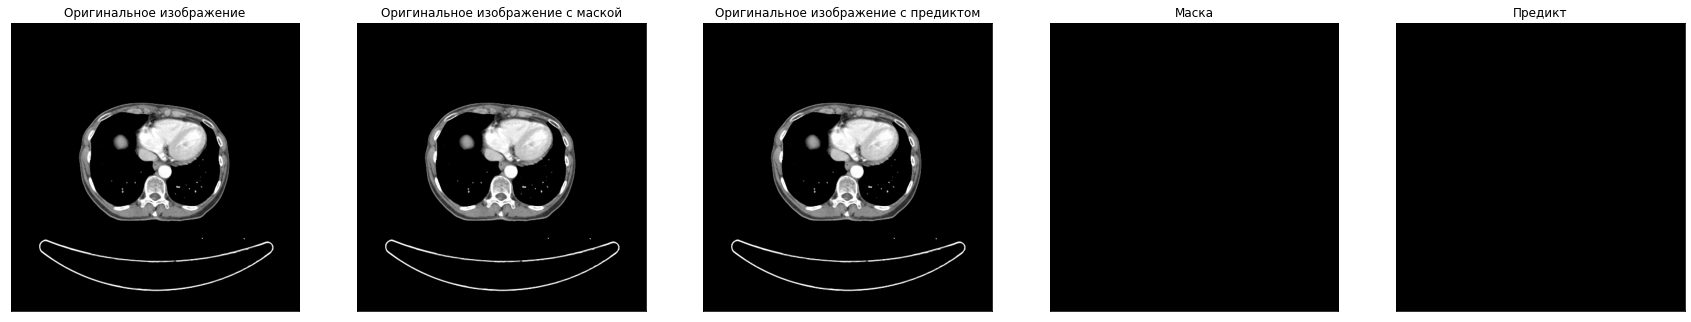

1/1 [==============================] - 0s 25ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-089/01-15-2006-StudyID-NA-71727/1.000000-NA-00092/1-77.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


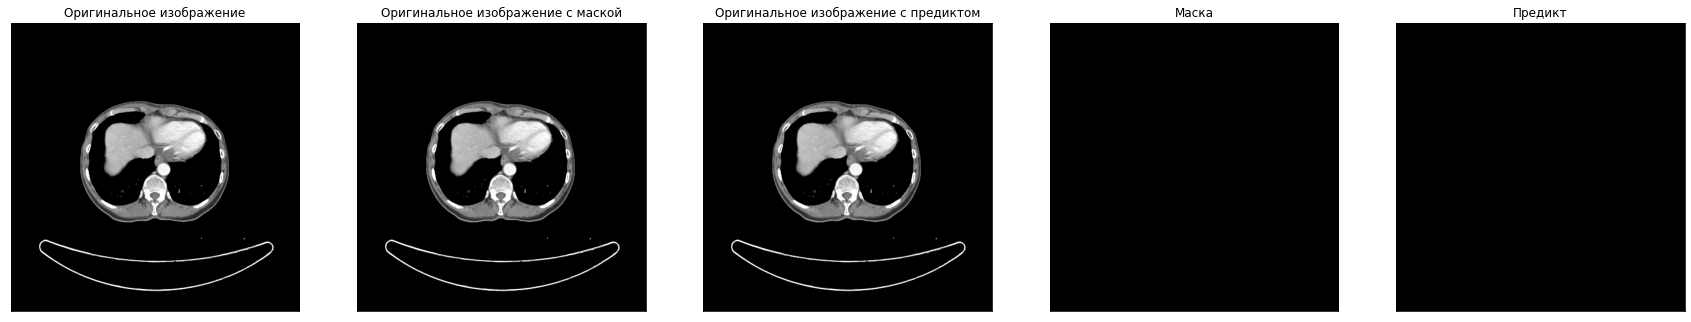

1/1 [==============================] - 0s 18ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-089/01-15-2006-StudyID-NA-71727/1.000000-NA-00092/1-94.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


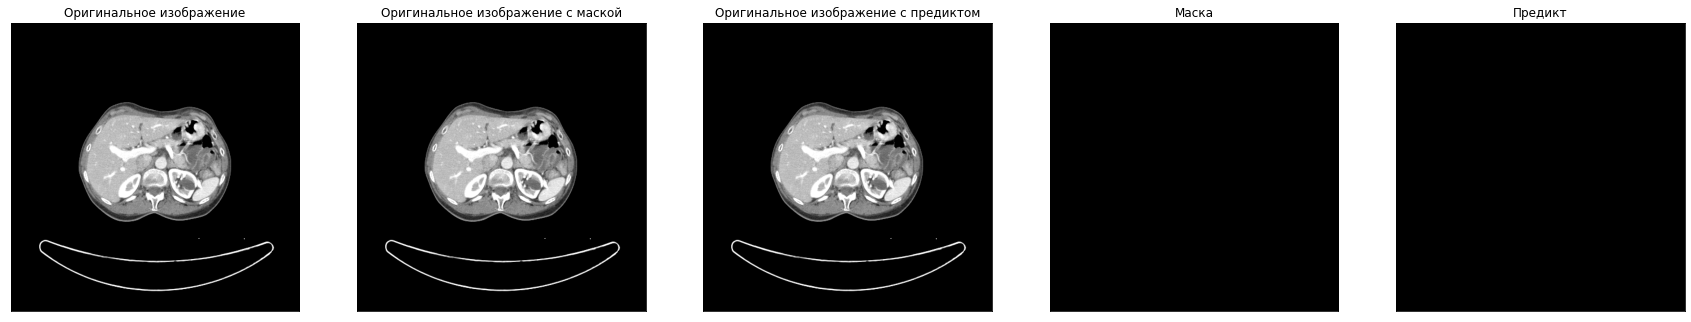

1/1 [==============================] - 0s 21ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-343/05-14-2009-StudyID-NA-95338/0.000000-NA-84394/1-28.dcm
Для данного кадра в левом легком обнаружено 12 пикселей выпота, объём 34.332275390625 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 12 пикселей выпота, объём 34.332275390625 мм3


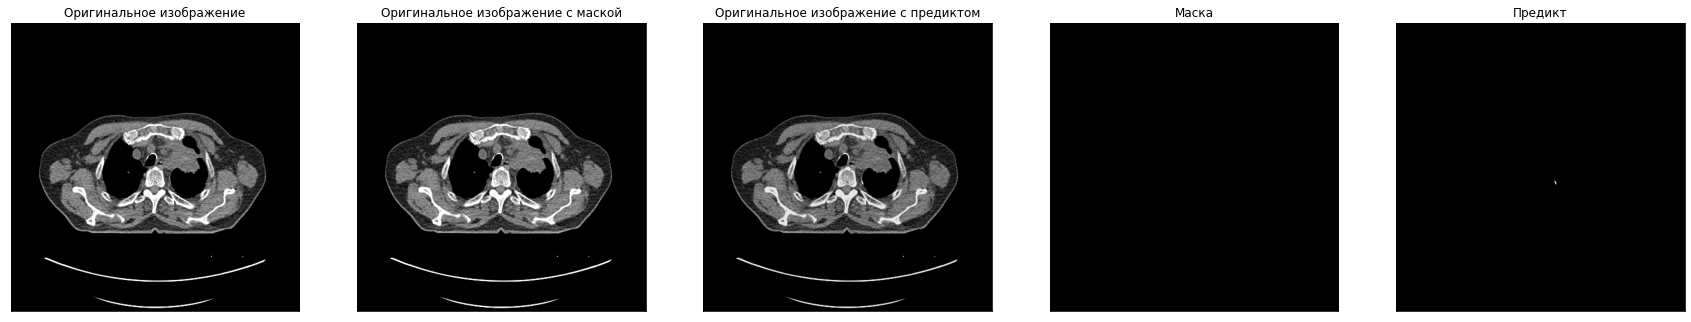

1/1 [==============================] - 0s 24ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-343/05-14-2009-StudyID-NA-95338/0.000000-NA-84394/1-33.dcm
Для данного кадра в левом легком обнаружено 75 пикселей выпота, объём 214.57672119140625 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 75 пикселей выпота, объём 214.57672119140625 мм3


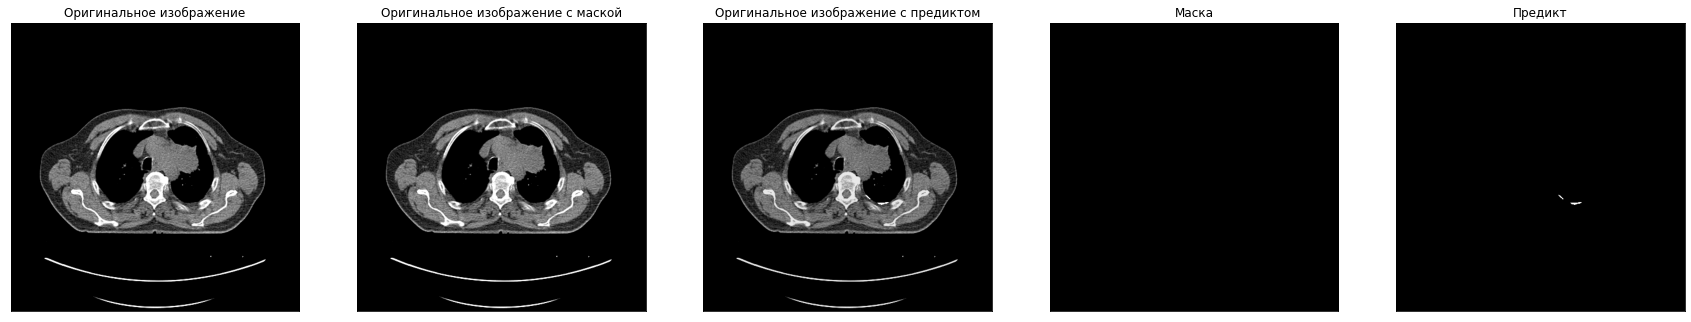

1/1 [==============================] - 0s 29ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-343/05-14-2009-StudyID-NA-95338/0.000000-NA-84394/1-57.dcm
Для данного кадра в левом легком обнаружено 1542 пикселей выпота, объём 4411.6973876953125 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 1542 пикселей выпота, объём 4411.6973876953125 мм3


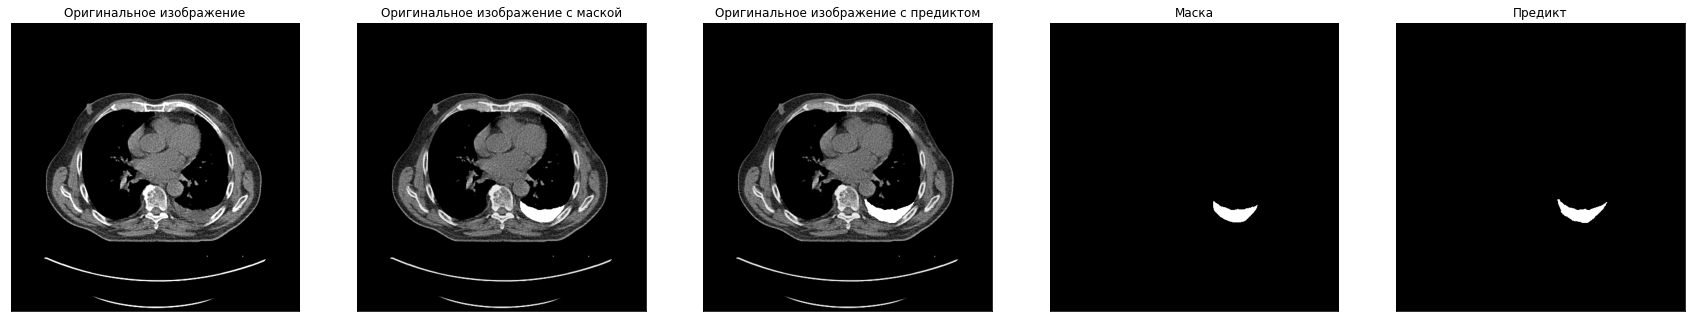

1/1 [==============================] - 0s 34ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-343/05-14-2009-StudyID-NA-95338/0.000000-NA-84394/1-65.dcm
Для данного кадра в левом легком обнаружено 1813 пикселей выпота, объём 5187.034606933594 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 1813 пикселей выпота, объём 5187.034606933594 мм3


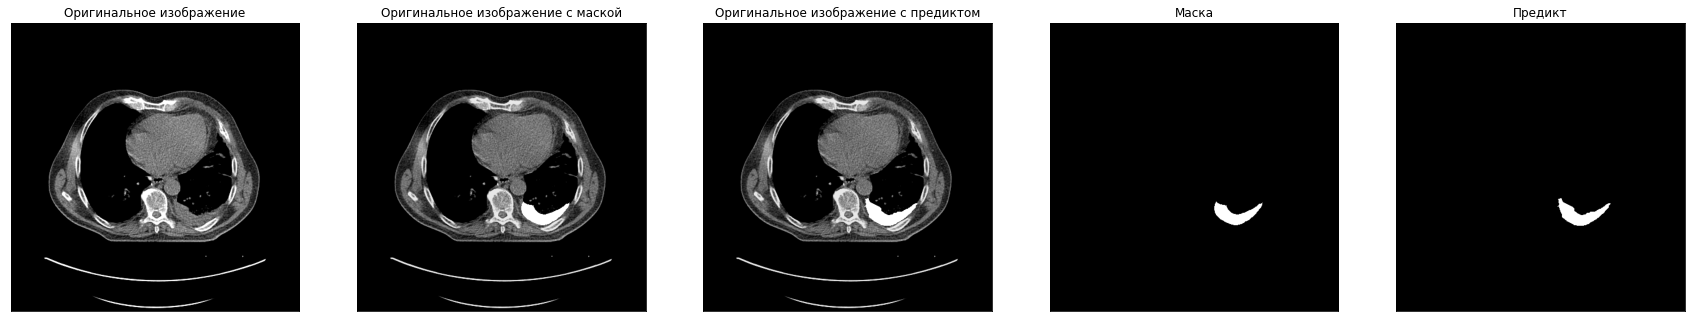

1/1 [==============================] - 0s 34ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-343/05-14-2009-StudyID-NA-95338/0.000000-NA-84394/1-81.dcm
Для данного кадра в левом легком обнаружено 979 пикселей выпота, объём 2800.9414672851562 мм3
Для данного кадра в правом легком обнаружено 15 пикселей выпота, объём 42.91534423828125 мм3
Для данного кадра всего обнаружено 994 пикселей выпота, объём 2843.8568115234375 мм3


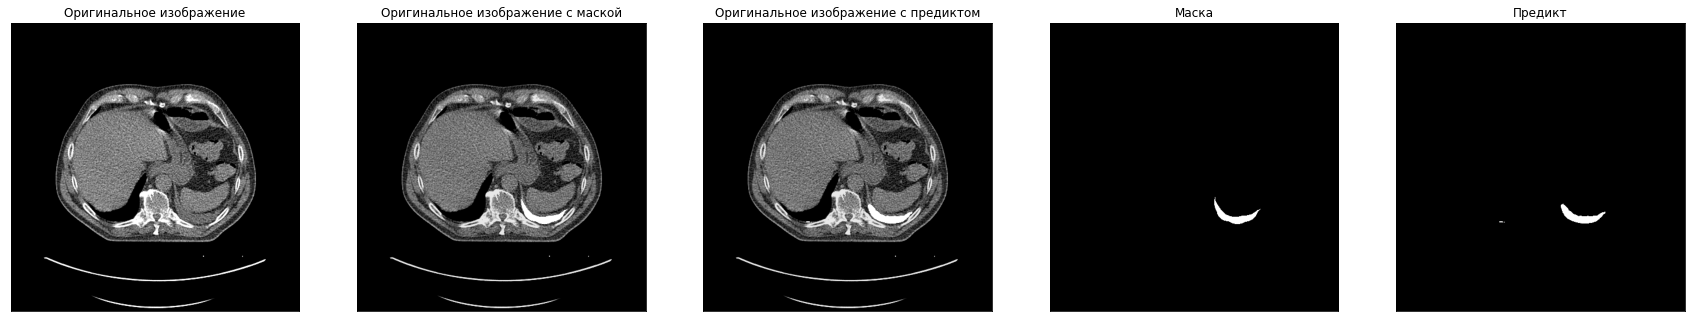

1/1 [==============================] - 0s 35ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-361/04-11-2010-NA-NA-81795/0.000000-NA-56193/1-001.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


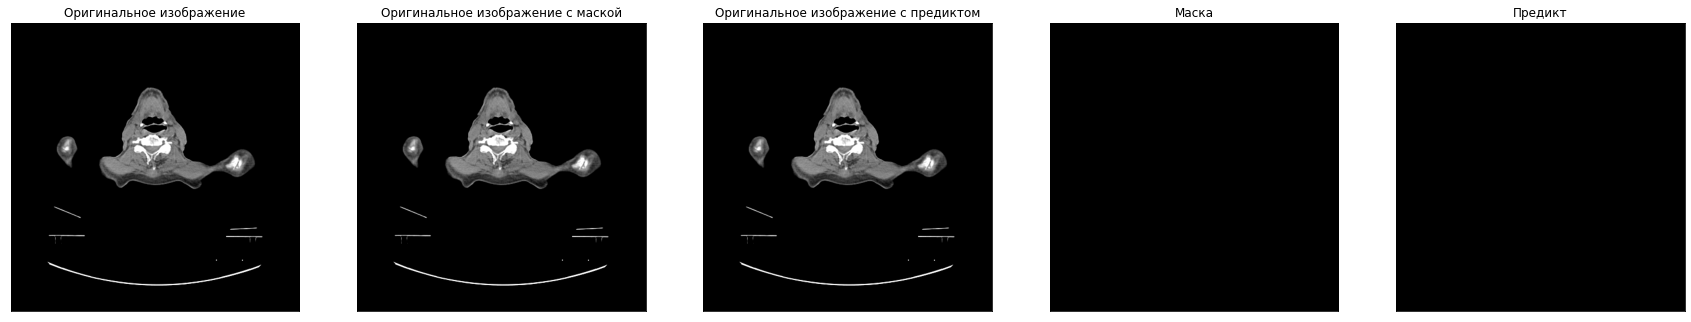

1/1 [==============================] - 0s 31ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-361/04-11-2010-NA-NA-81795/0.000000-NA-56193/1-030.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


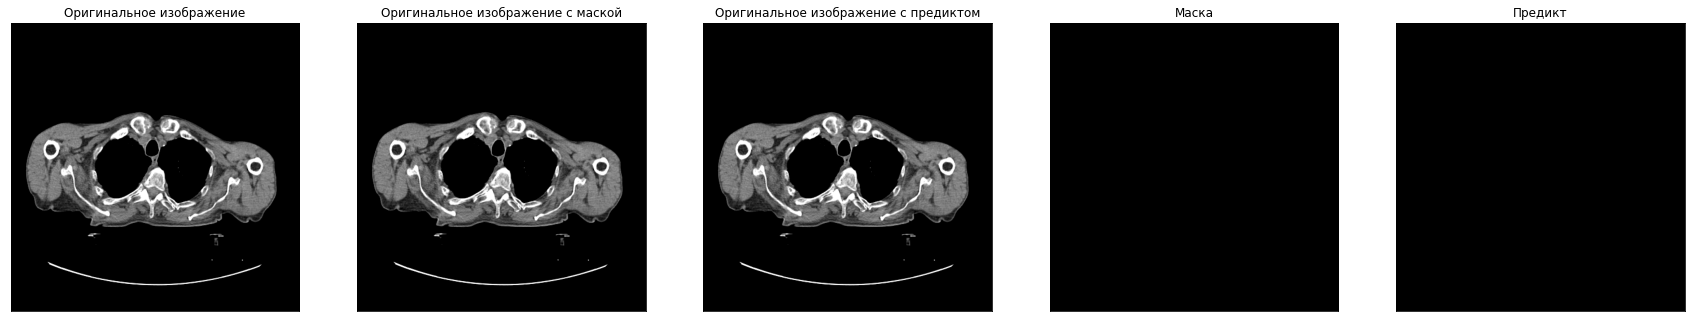

1/1 [==============================] - 0s 20ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-361/04-11-2010-NA-NA-81795/0.000000-NA-56193/1-044.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


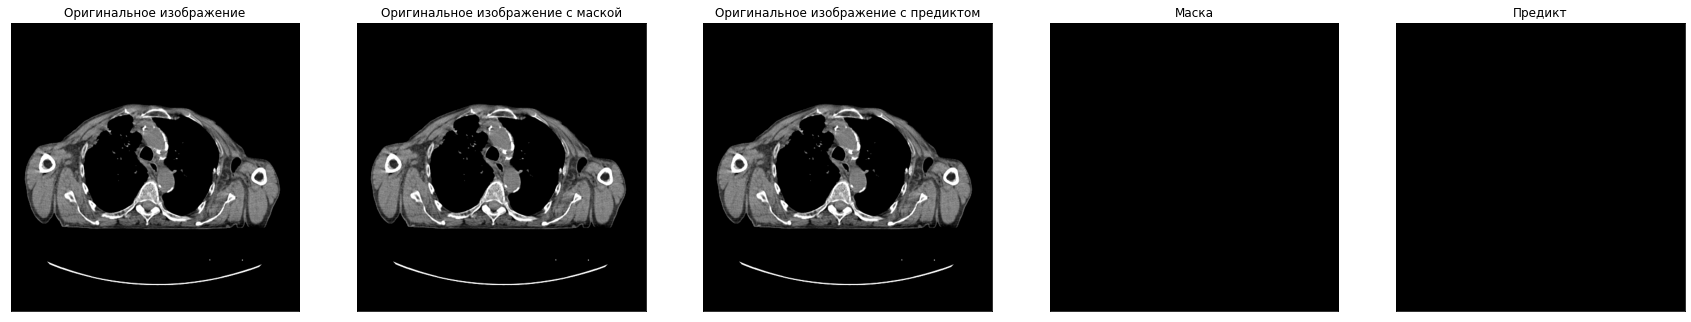

1/1 [==============================] - 0s 19ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-361/04-11-2010-NA-NA-81795/0.000000-NA-56193/1-054.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 26 пикселей выпота, объём 74.3865966796875 мм3
Для данного кадра всего обнаружено 26 пикселей выпота, объём 74.3865966796875 мм3


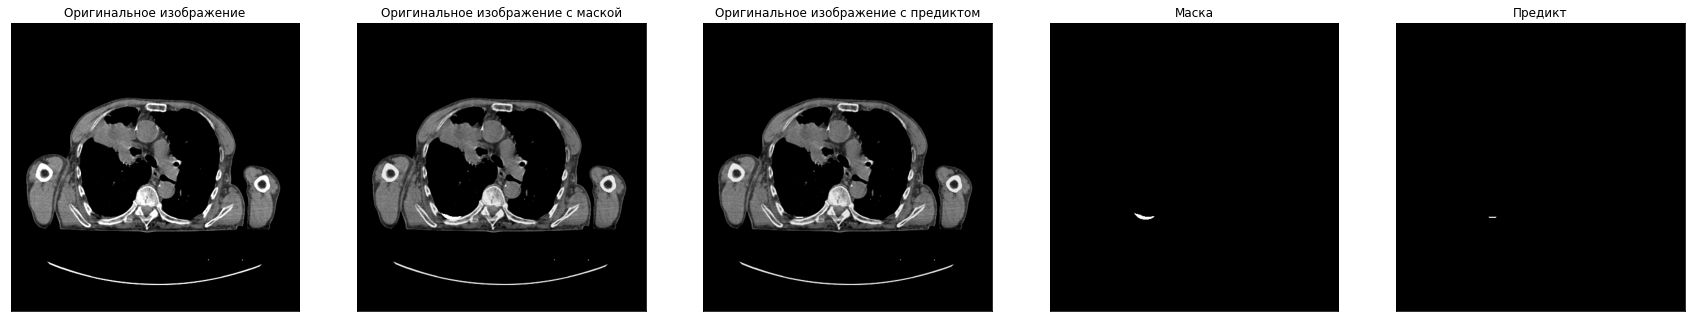

1/1 [==============================] - 0s 23ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-361/04-11-2010-NA-NA-81795/0.000000-NA-56193/1-067.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 456 пикселей выпота, объём 1304.62646484375 мм3
Для данного кадра всего обнаружено 456 пикселей выпота, объём 1304.62646484375 мм3


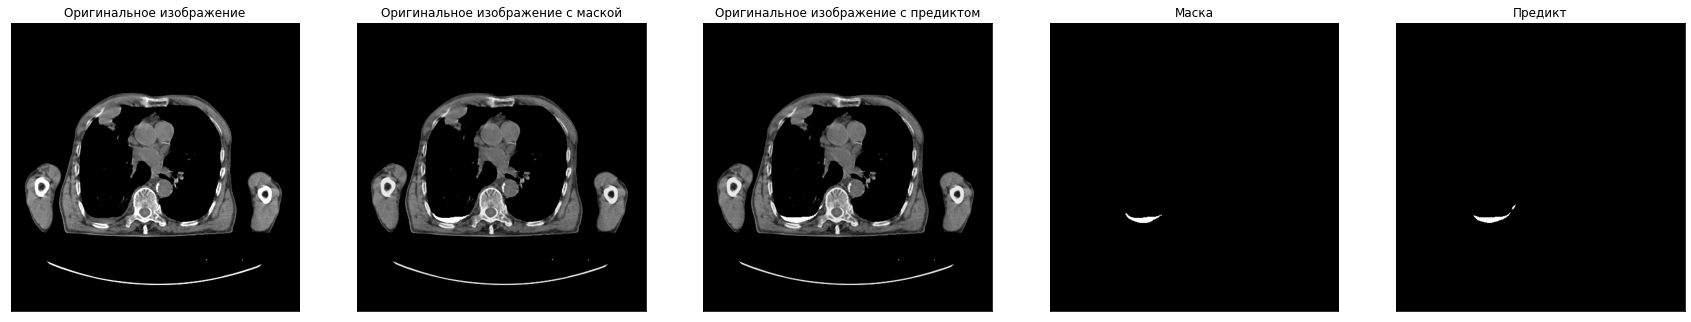

1/1 [==============================] - 0s 20ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-361/04-11-2010-NA-NA-81795/0.000000-NA-56193/1-071.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 447 пикселей выпота, объём 1278.8772583007812 мм3
Для данного кадра всего обнаружено 447 пикселей выпота, объём 1278.8772583007812 мм3


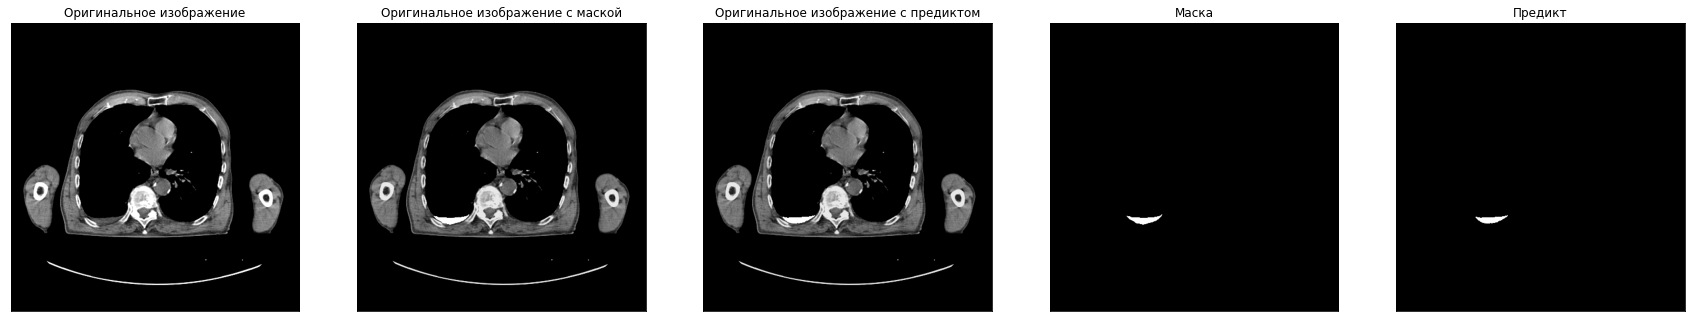

1/1 [==============================] - 0s 22ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-361/04-11-2010-NA-NA-81795/0.000000-NA-56193/1-082.dcm
Для данного кадра в левом легком обнаружено 56 пикселей выпота, объём 160.21728515625 мм3
Для данного кадра в правом легком обнаружено 411 пикселей выпота, объём 1175.8804321289062 мм3
Для данного кадра всего обнаружено 467 пикселей выпота, объём 1336.0977172851562 мм3


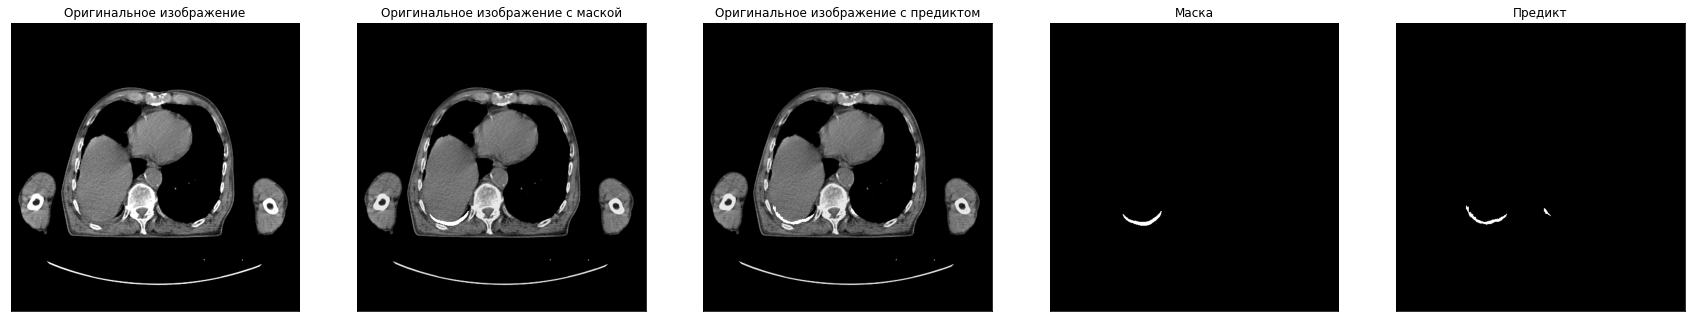

1/1 [==============================] - 0s 20ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-361/04-11-2010-NA-NA-81795/0.000000-NA-56193/1-126.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


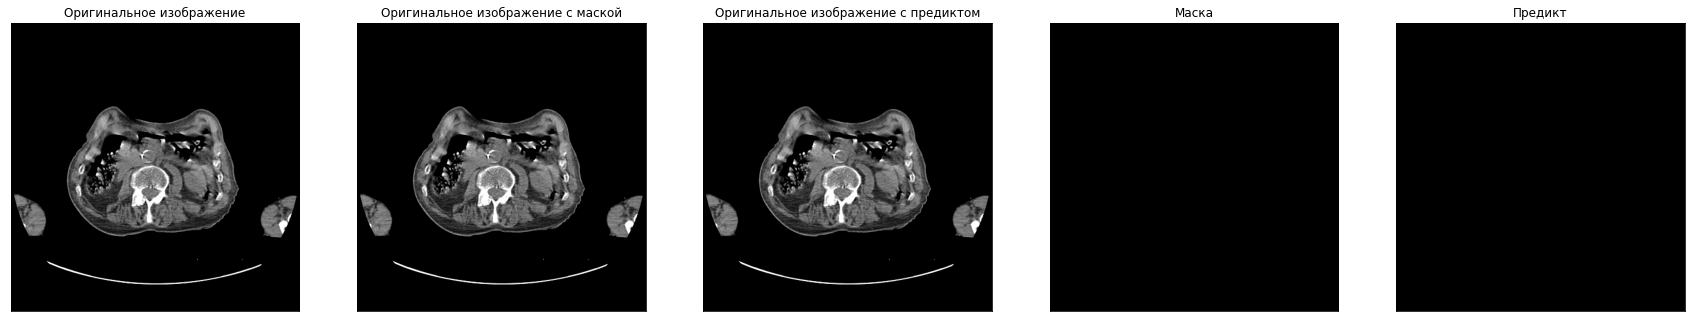

1/1 [==============================] - 0s 22ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-366/04-12-2010-NA-NA-44824/0.000000-NA-58053/1-014.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


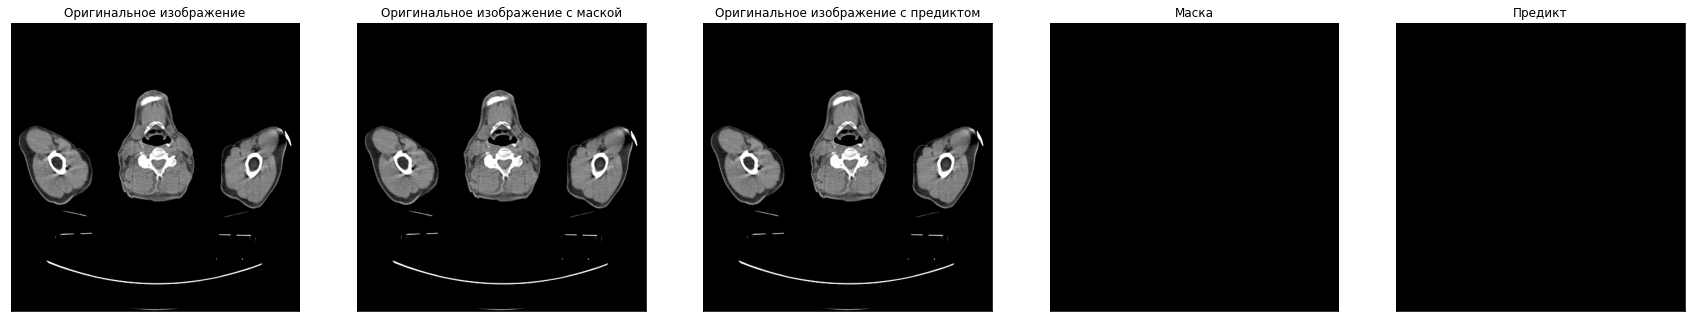

1/1 [==============================] - 0s 19ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-366/04-12-2010-NA-NA-44824/0.000000-NA-58053/1-040.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


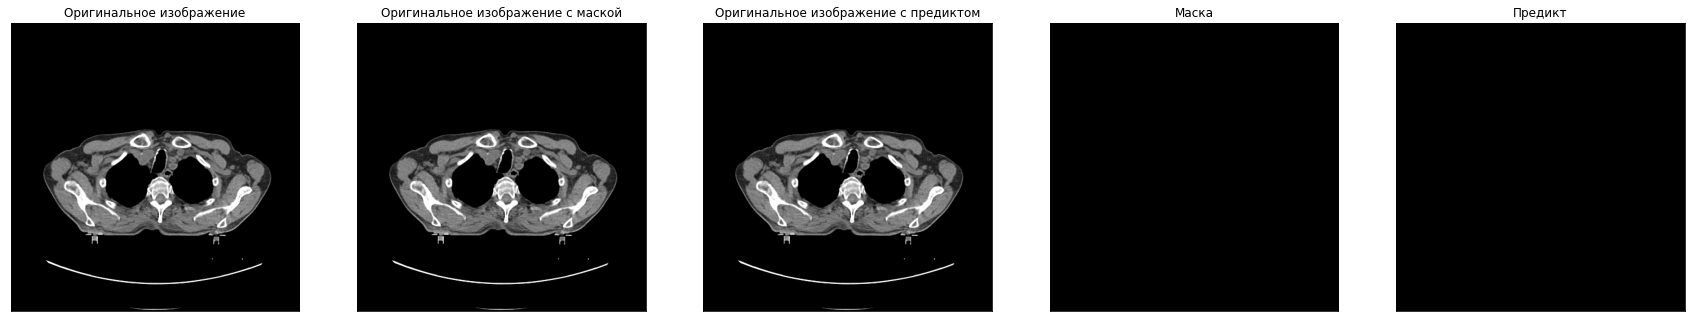

1/1 [==============================] - 0s 19ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-366/04-12-2010-NA-NA-44824/0.000000-NA-58053/1-058.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


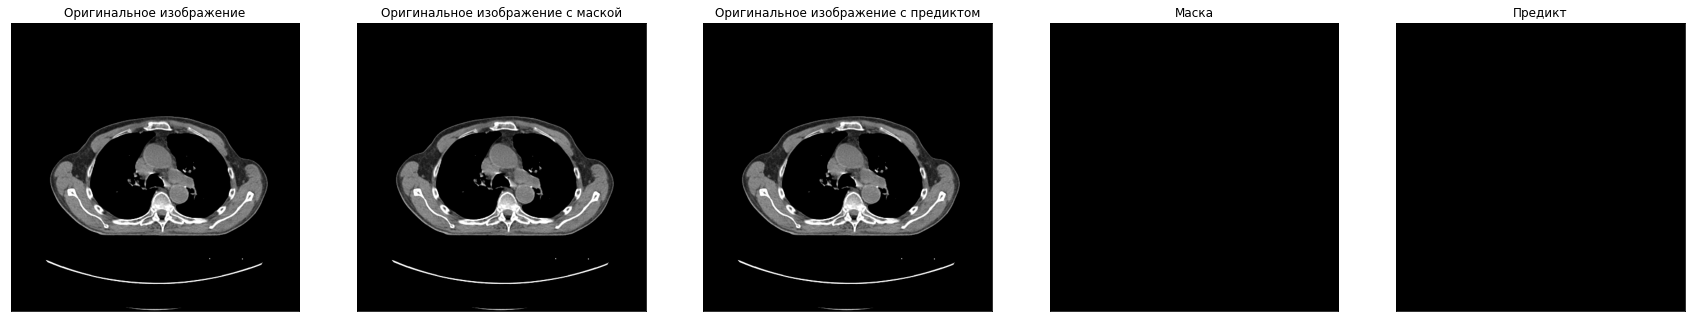

1/1 [==============================] - 0s 19ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-366/04-12-2010-NA-NA-44824/0.000000-NA-58053/1-062.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


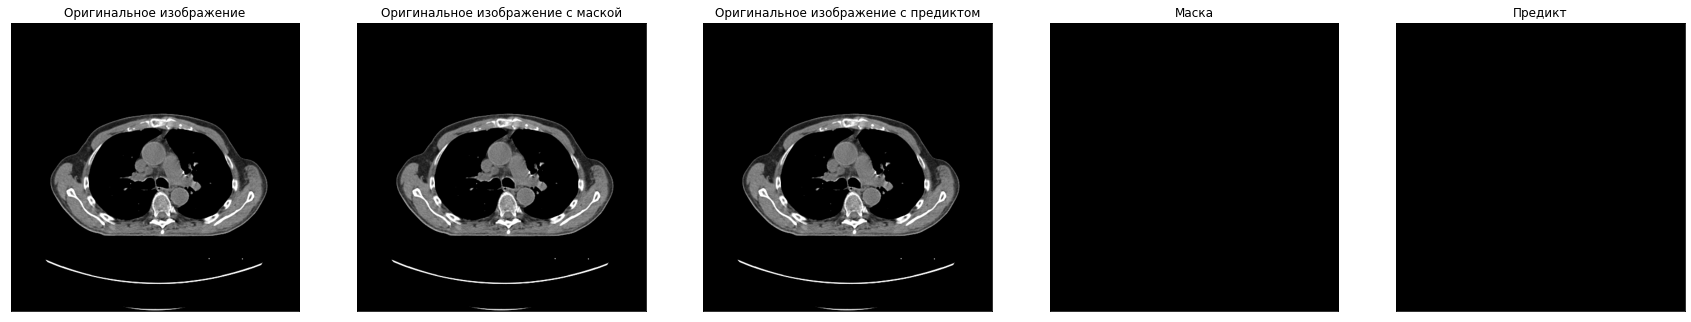

1/1 [==============================] - 0s 21ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-366/04-12-2010-NA-NA-44824/0.000000-NA-58053/1-090.dcm
Для данного кадра в левом легком обнаружено 391 пикселей выпота, объём 1118.6599731445312 мм3
Для данного кадра в правом легком обнаружено 385 пикселей выпота, объём 1101.4938354492188 мм3
Для данного кадра всего обнаружено 776 пикселей выпота, объём 2220.15380859375 мм3


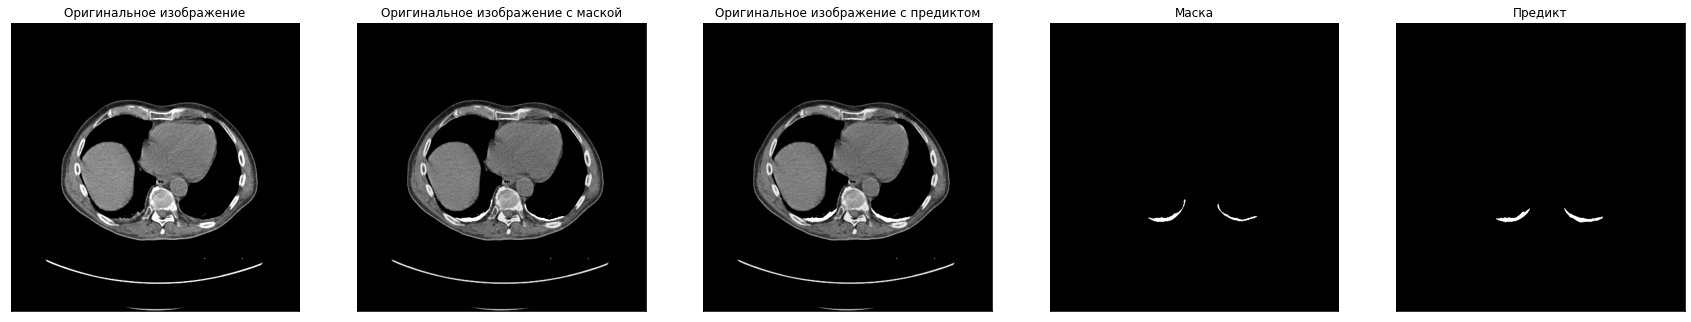

1/1 [==============================] - 0s 20ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-366/04-12-2010-NA-NA-44824/0.000000-NA-58053/1-108.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


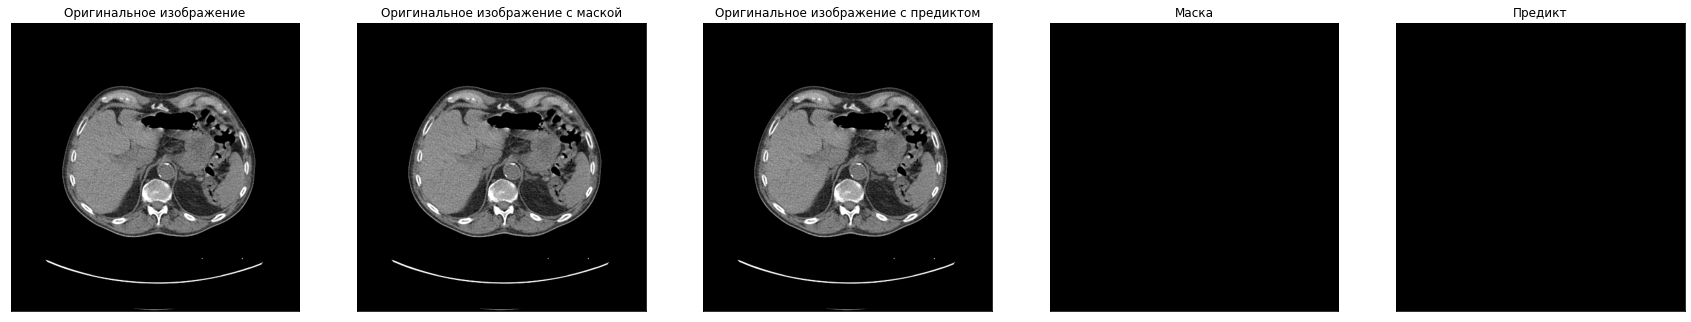

1/1 [==============================] - 0s 19ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-366/04-12-2010-NA-NA-44824/0.000000-NA-58053/1-125.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


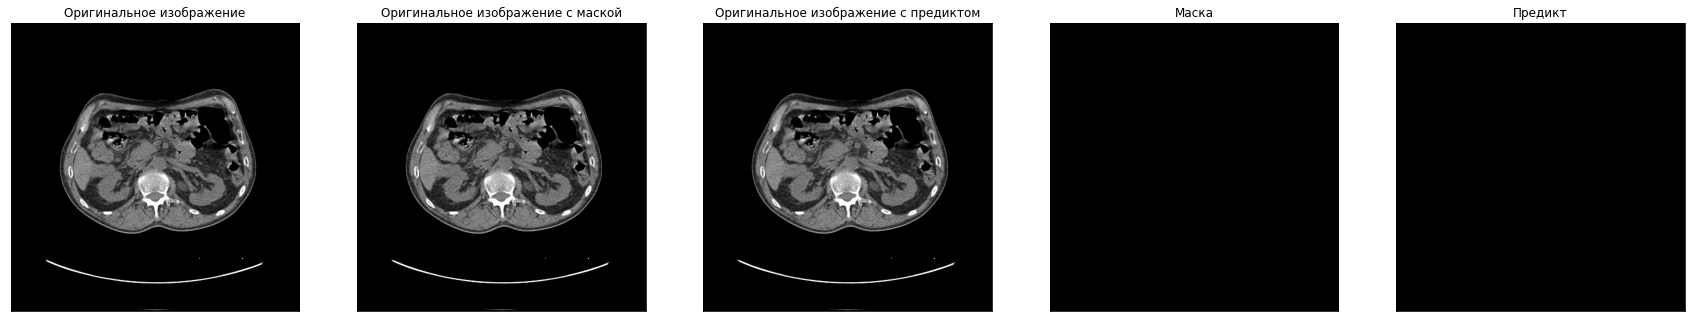

1/1 [==============================] - 0s 20ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-366/04-12-2010-NA-NA-44824/0.000000-NA-58053/1-127.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


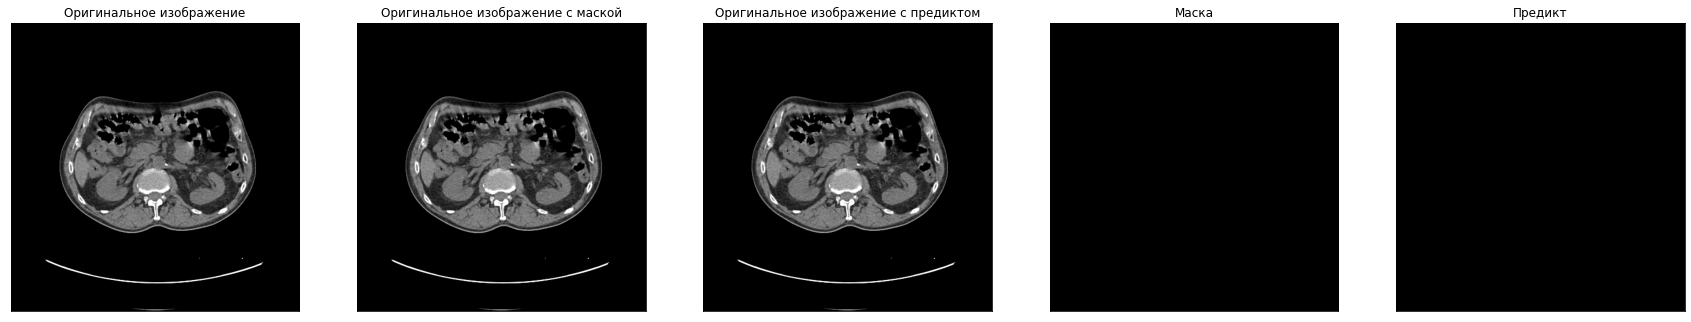

1/1 [==============================] - 0s 20ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-366/04-12-2010-NA-NA-44824/0.000000-NA-58053/1-129.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


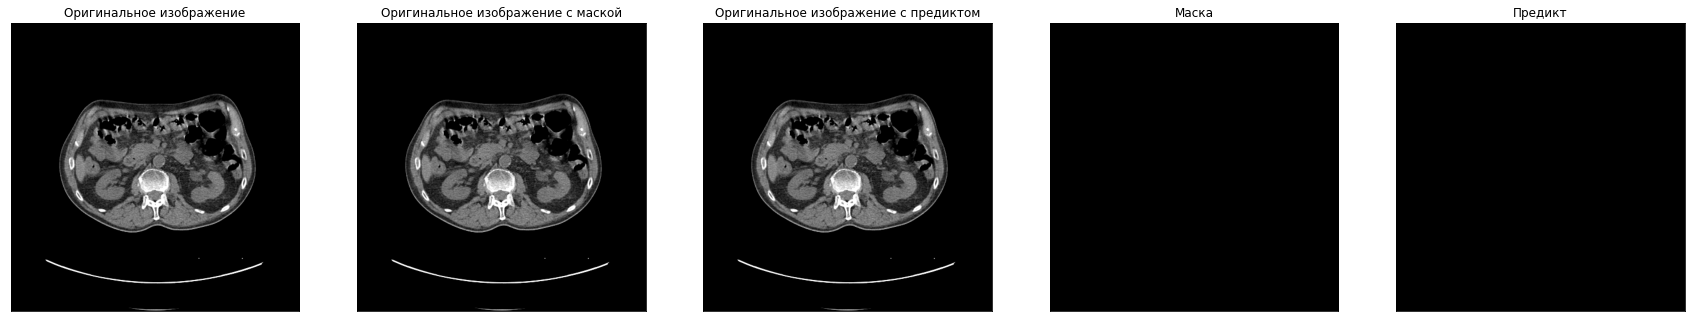

1/1 [==============================] - 0s 21ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-366/04-12-2010-NA-NA-44824/0.000000-NA-58053/1-133.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


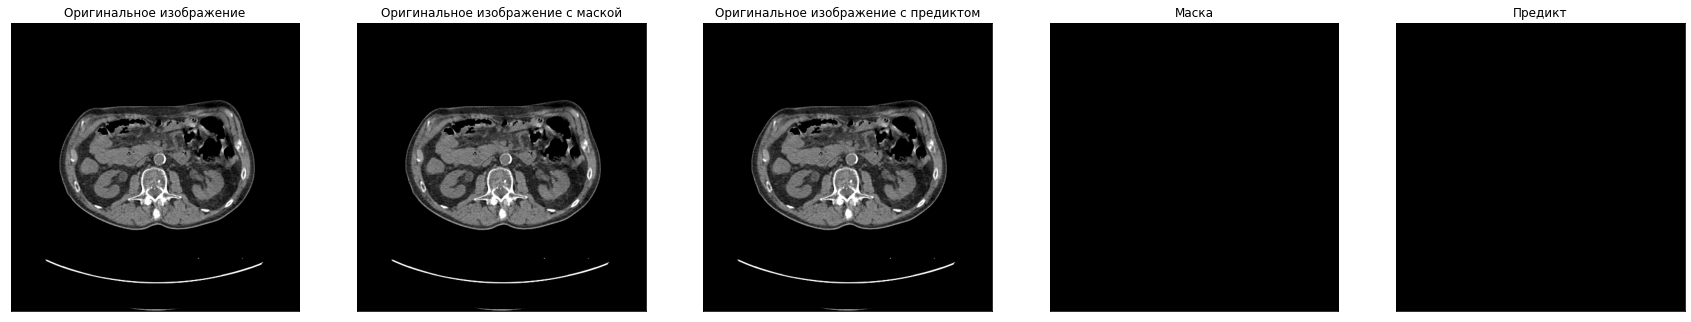

1/1 [==============================] - 0s 40ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-376/02-27-2010-NA-NA-88135/0.000000-NA-03101/1-009.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


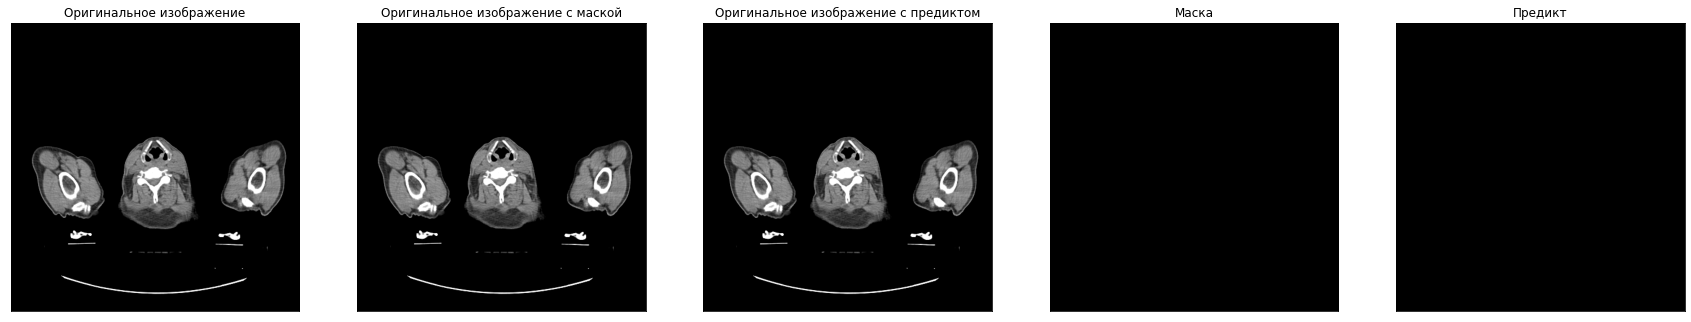

1/1 [==============================] - 0s 32ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-376/02-27-2010-NA-NA-88135/0.000000-NA-03101/1-024.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


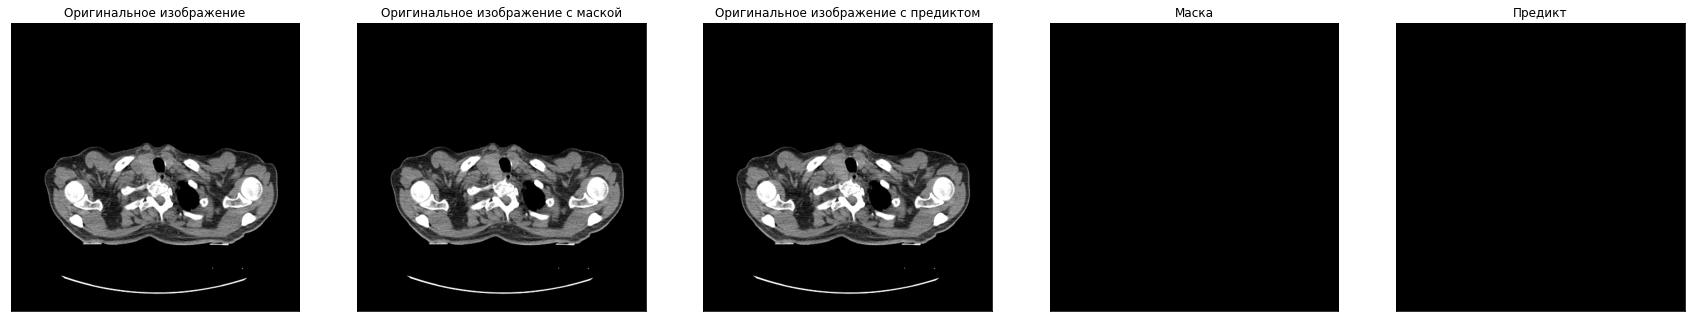

1/1 [==============================] - 0s 39ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-376/02-27-2010-NA-NA-88135/0.000000-NA-03101/1-043.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


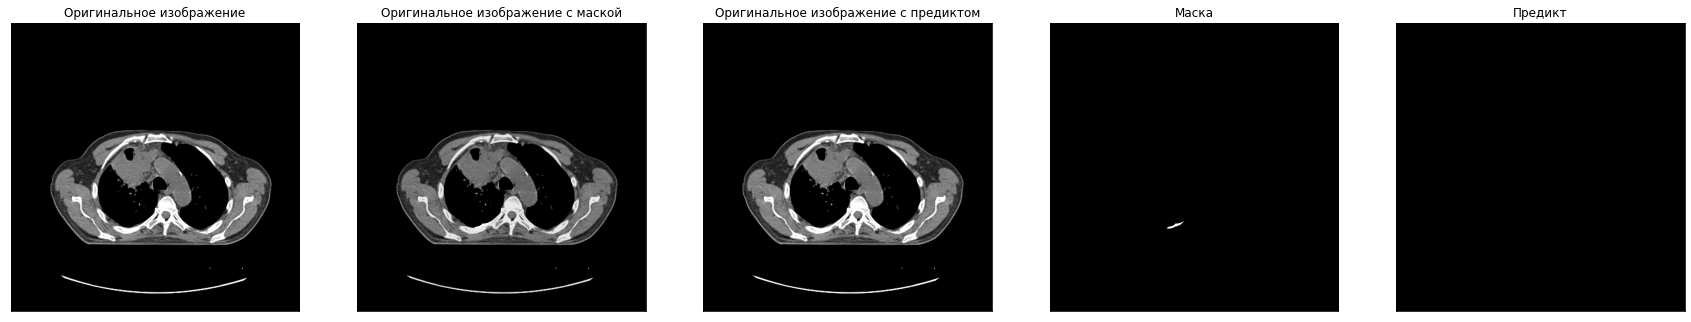

1/1 [==============================] - 0s 41ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-376/02-27-2010-NA-NA-88135/0.000000-NA-03101/1-044.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


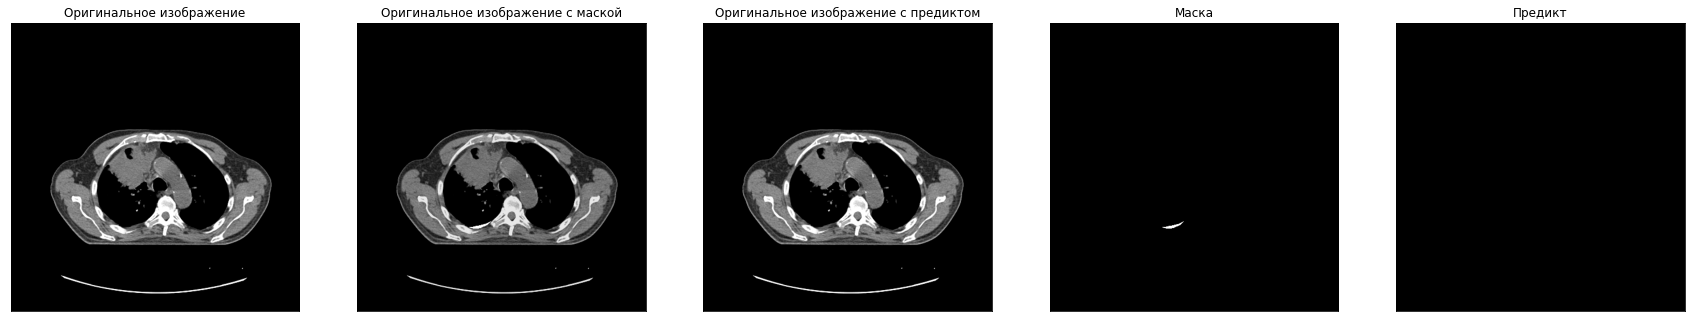

1/1 [==============================] - 0s 32ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-376/02-27-2010-NA-NA-88135/0.000000-NA-03101/1-051.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 532 пикселей выпота, объём 1522.064208984375 мм3
Для данного кадра всего обнаружено 532 пикселей выпота, объём 1522.064208984375 мм3


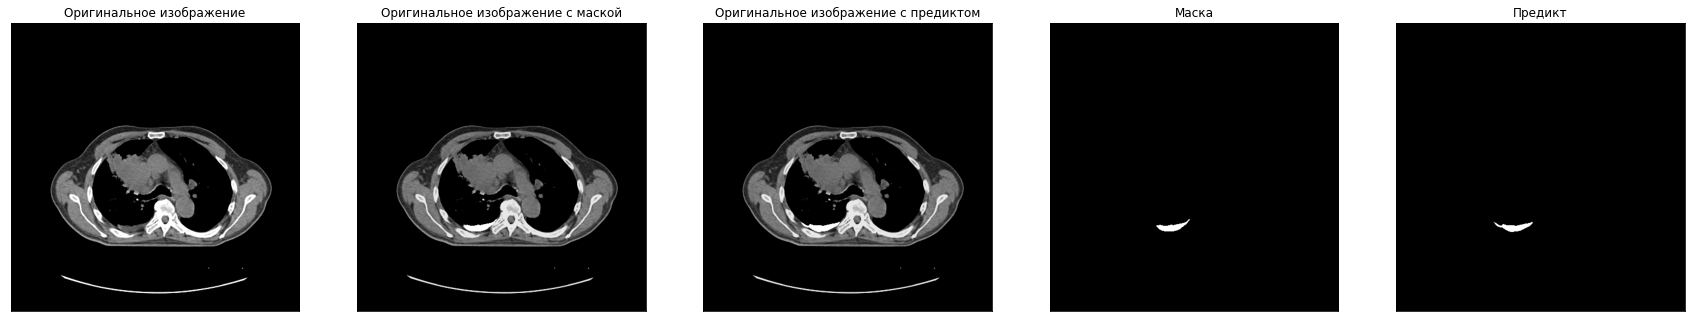

1/1 [==============================] - 0s 20ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-376/02-27-2010-NA-NA-88135/0.000000-NA-03101/1-072.dcm
Для данного кадра в левом легком обнаружено 85 пикселей выпота, объём 243.18695068359375 мм3
Для данного кадра в правом легком обнаружено 1155 пикселей выпота, объём 3304.4815063476562 мм3
Для данного кадра всего обнаружено 1240 пикселей выпота, объём 3547.66845703125 мм3


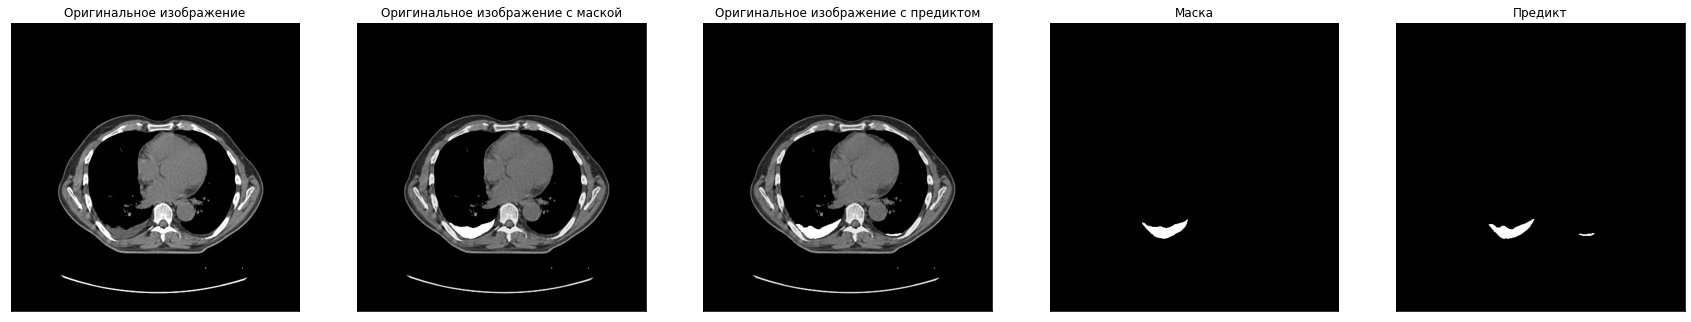

1/1 [==============================] - 0s 20ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-376/02-27-2010-NA-NA-88135/0.000000-NA-03101/1-087.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 731 пикселей выпота, объём 2091.4077758789062 мм3
Для данного кадра всего обнаружено 731 пикселей выпота, объём 2091.4077758789062 мм3


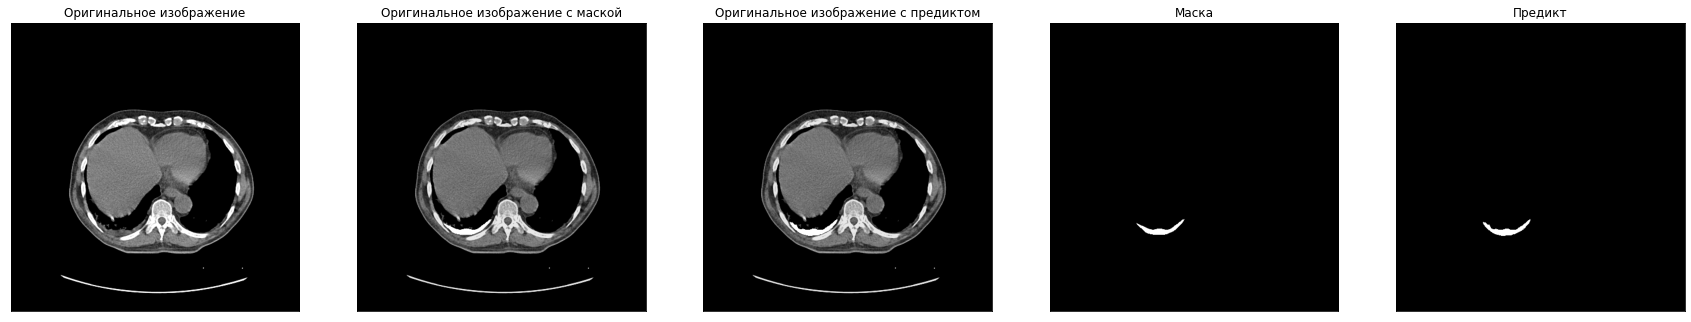

1/1 [==============================] - 0s 26ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-376/02-27-2010-NA-NA-88135/0.000000-NA-03101/1-093.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 964 пикселей выпота, объём 2758.026123046875 мм3
Для данного кадра всего обнаружено 964 пикселей выпота, объём 2758.026123046875 мм3


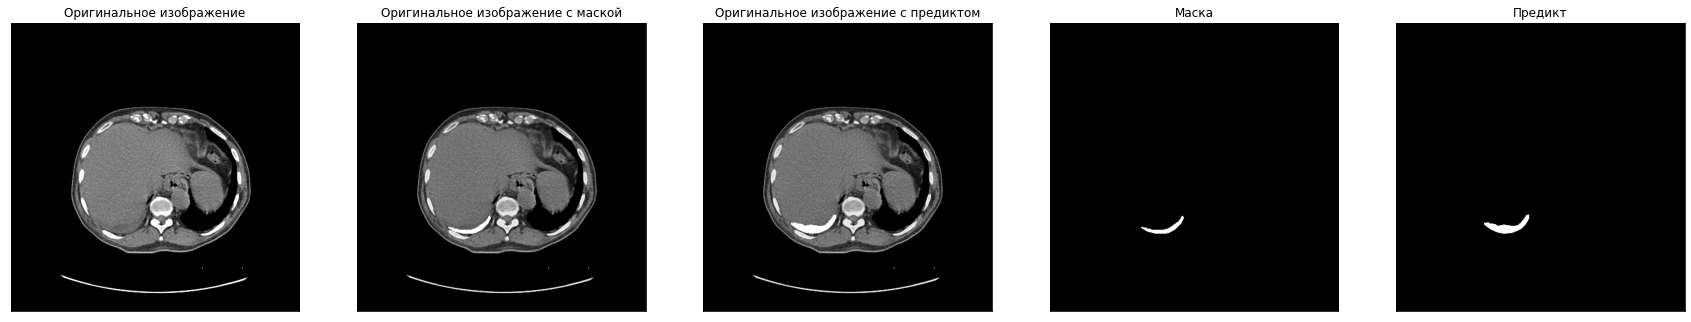

1/1 [==============================] - 0s 26ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-376/02-27-2010-NA-NA-88135/0.000000-NA-03101/1-103.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


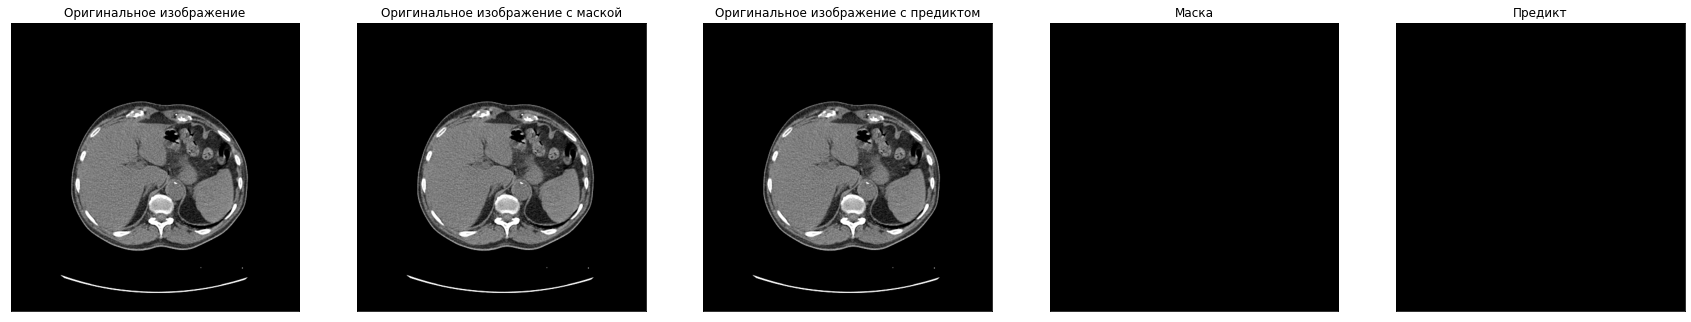

1/1 [==============================] - 0s 19ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-376/02-27-2010-NA-NA-88135/0.000000-NA-03101/1-105.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


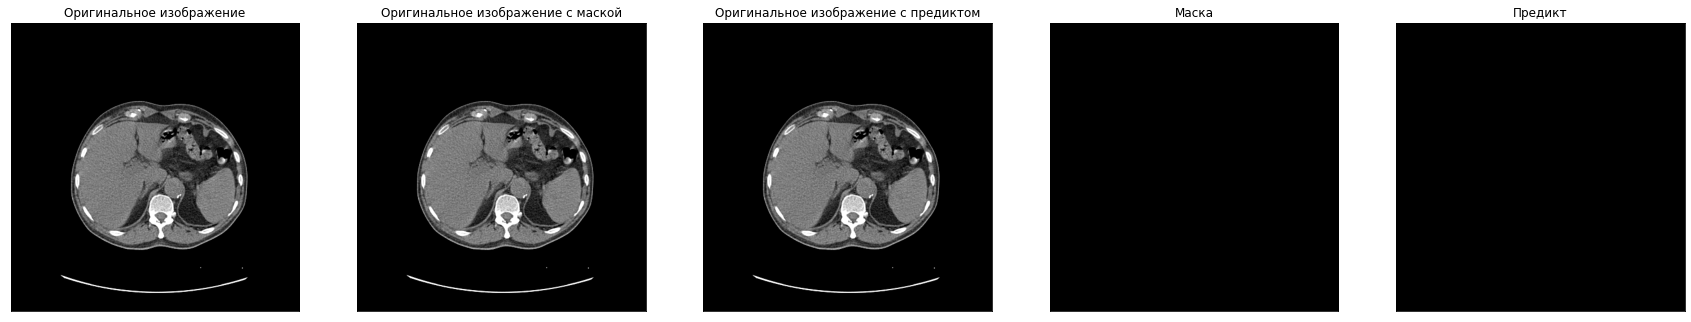

1/1 [==============================] - 0s 18ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-376/02-27-2010-NA-NA-88135/0.000000-NA-03101/1-109.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


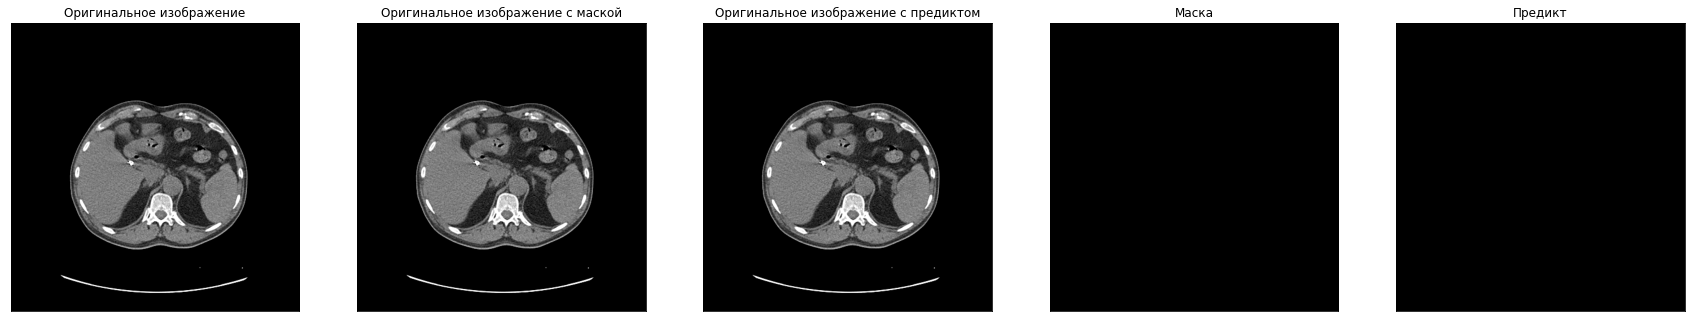

1/1 [==============================] - 0s 22ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-377/03-04-2010-NA-NA-80035/0.000000-NA-67530/1-022.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


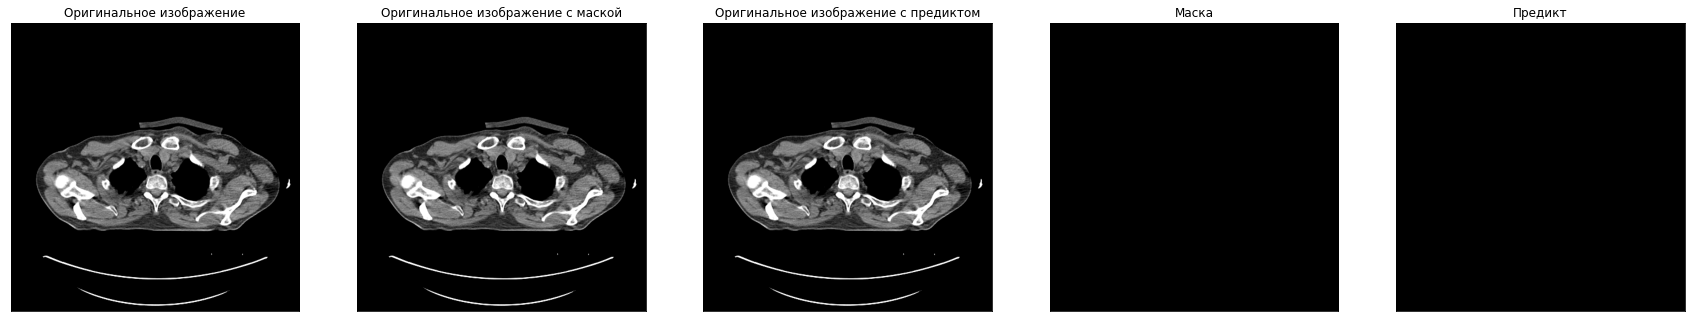

1/1 [==============================] - 0s 21ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-377/03-04-2010-NA-NA-80035/0.000000-NA-67530/1-043.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


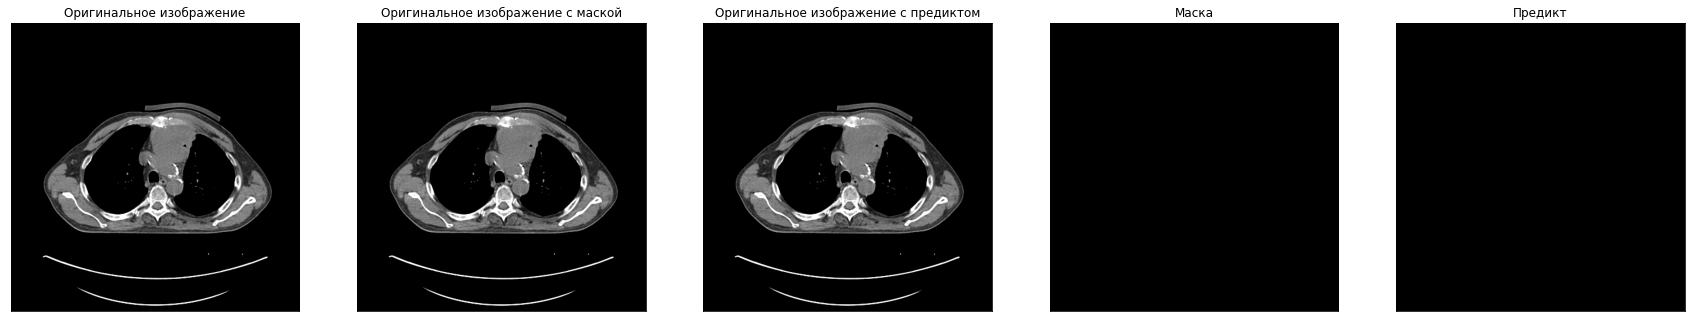

1/1 [==============================] - 0s 21ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-377/03-04-2010-NA-NA-80035/0.000000-NA-67530/1-067.dcm
Для данного кадра в левом легком обнаружено 2 пикселей выпота, объём 5.7220458984375 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 2 пикселей выпота, объём 5.7220458984375 мм3


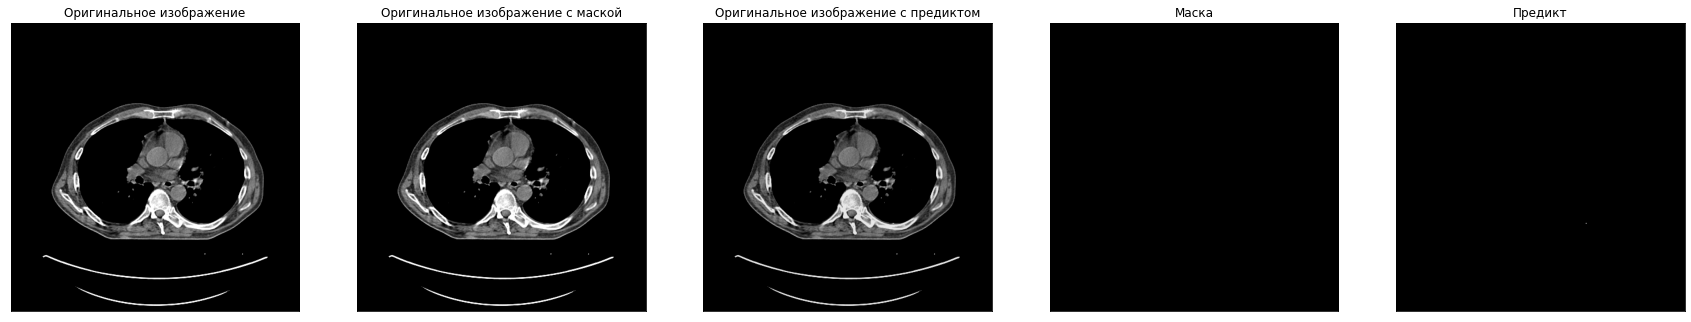

1/1 [==============================] - 0s 20ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-377/03-04-2010-NA-NA-80035/0.000000-NA-67530/1-072.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


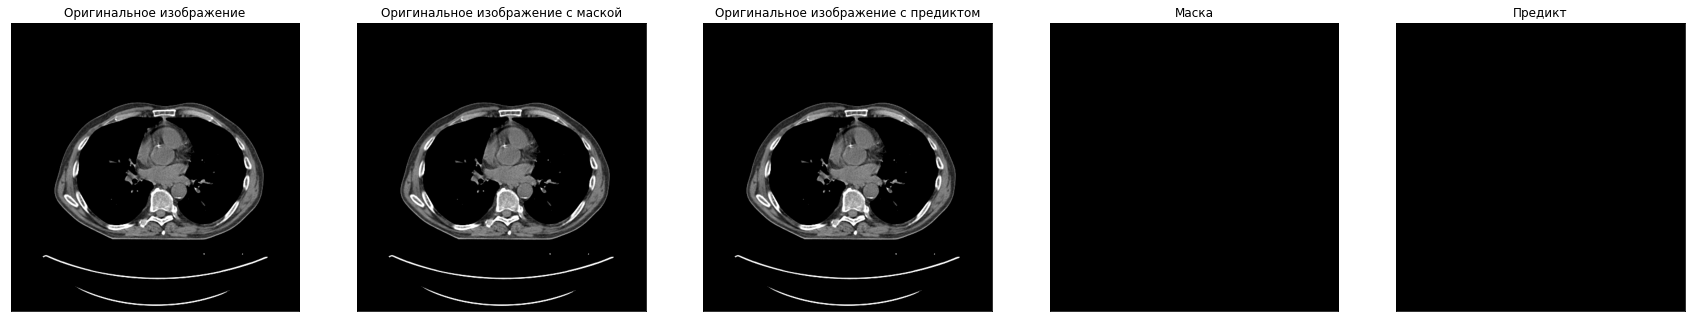

1/1 [==============================] - 0s 27ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-377/03-04-2010-NA-NA-80035/0.000000-NA-67530/1-084.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


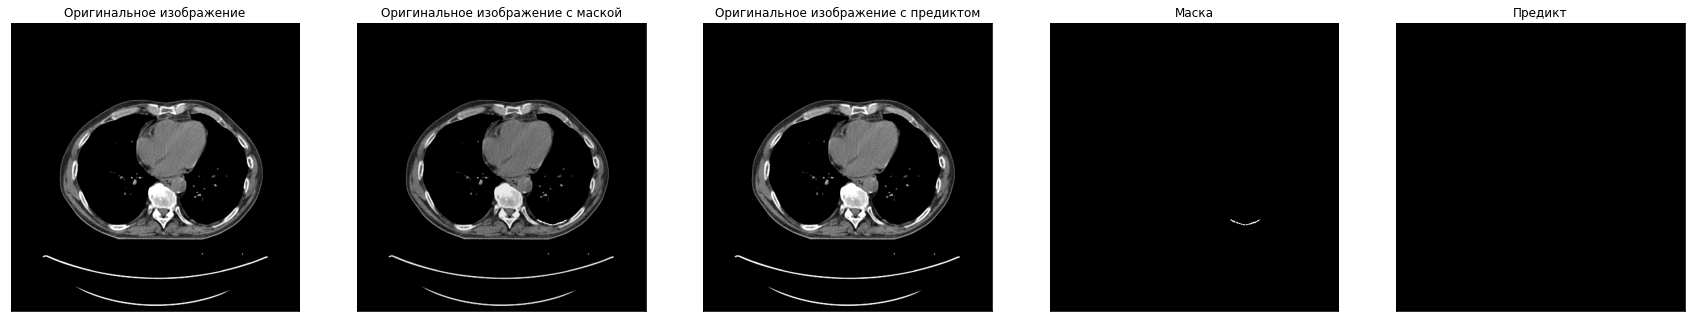

1/1 [==============================] - 0s 31ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-377/03-04-2010-NA-NA-80035/0.000000-NA-67530/1-091.dcm
Для данного кадра в левом легком обнаружено 137 пикселей выпота, объём 391.96014404296875 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 137 пикселей выпота, объём 391.96014404296875 мм3


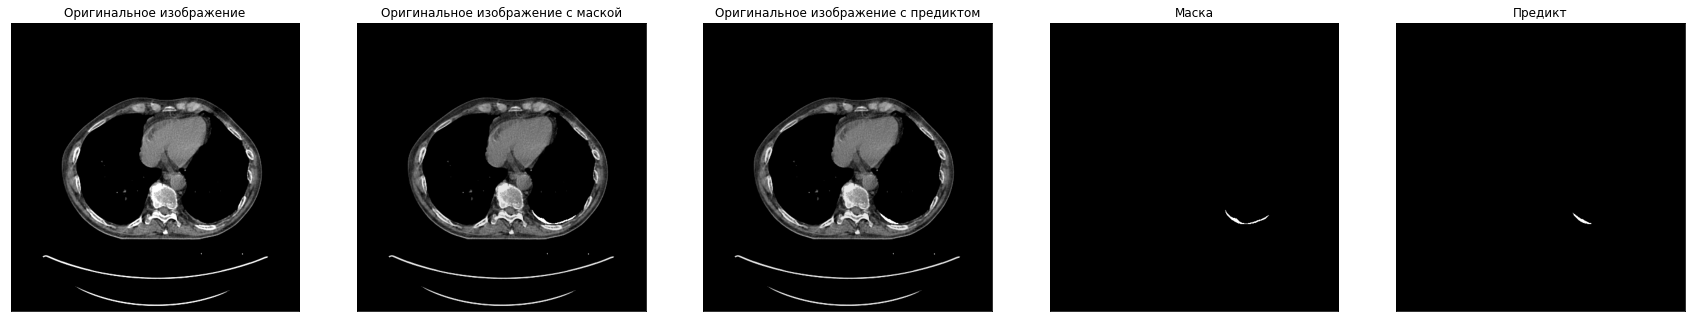

1/1 [==============================] - 0s 24ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-377/03-04-2010-NA-NA-80035/0.000000-NA-67530/1-102.dcm
Для данного кадра в левом легком обнаружено 1097 пикселей выпота, объём 3138.5421752929688 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 1097 пикселей выпота, объём 3138.5421752929688 мм3


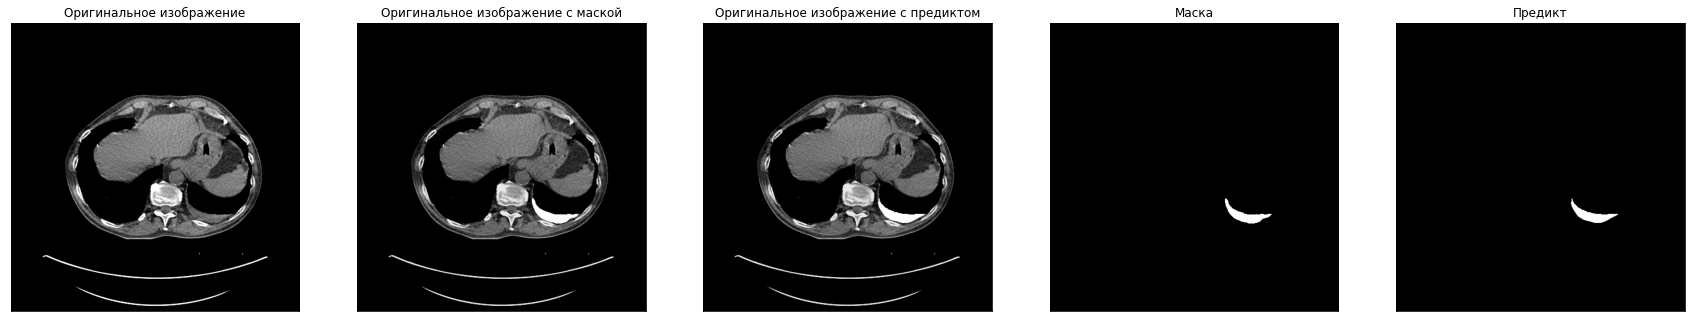

1/1 [==============================] - 0s 28ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-416/07-30-2010-NA-NA-71000/0.000000-NA-44349/1-020.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


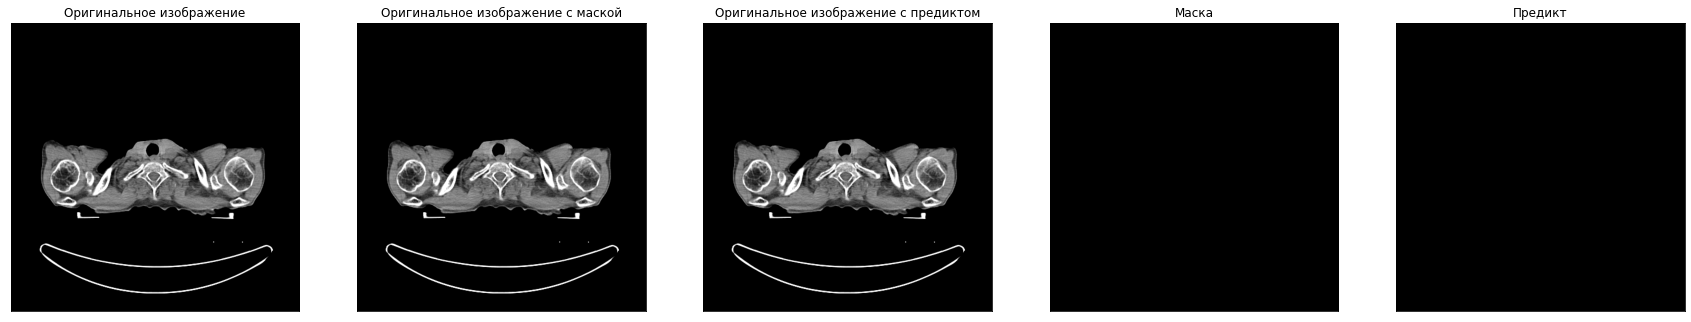

1/1 [==============================] - 0s 22ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-416/07-30-2010-NA-NA-71000/0.000000-NA-44349/1-046.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 188 пикселей выпота, объём 537.872314453125 мм3
Для данного кадра всего обнаружено 188 пикселей выпота, объём 537.872314453125 мм3


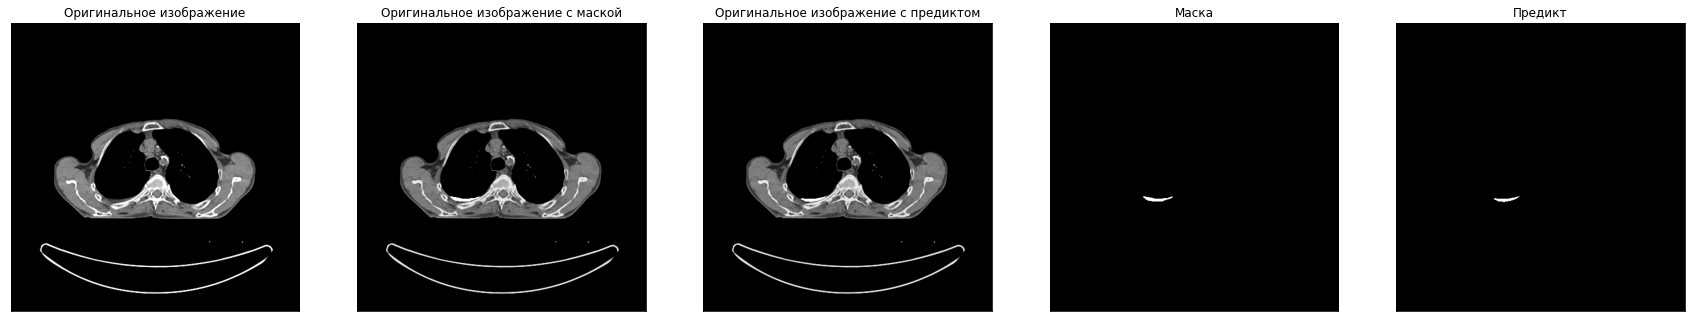

1/1 [==============================] - 0s 27ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-416/07-30-2010-NA-NA-71000/0.000000-NA-44349/1-050.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 351 пикселей выпота, объём 1004.2190551757812 мм3
Для данного кадра всего обнаружено 351 пикселей выпота, объём 1004.2190551757812 мм3


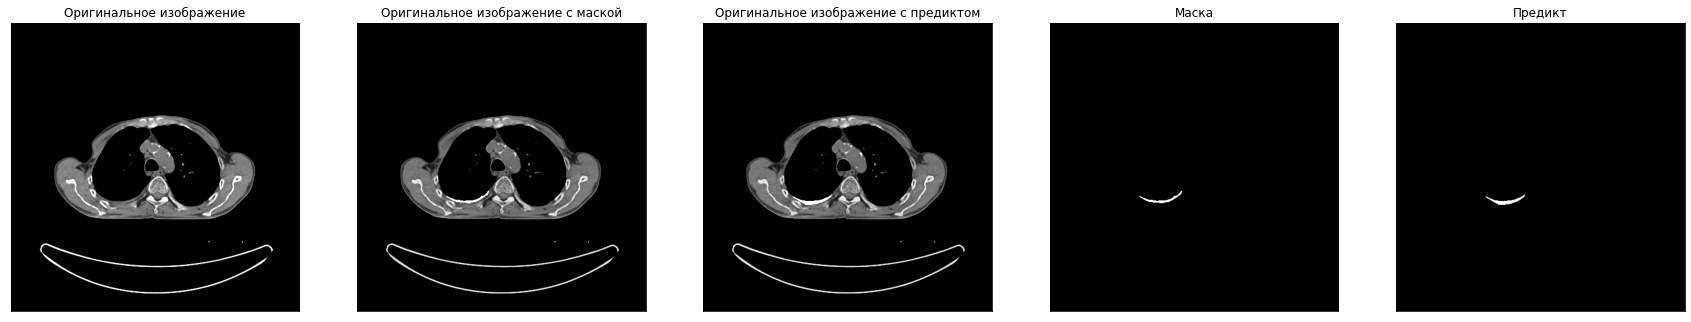

1/1 [==============================] - 0s 41ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-416/07-30-2010-NA-NA-71000/0.000000-NA-44349/1-064.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 702 пикселей выпота, объём 2008.4381103515625 мм3
Для данного кадра всего обнаружено 702 пикселей выпота, объём 2008.4381103515625 мм3


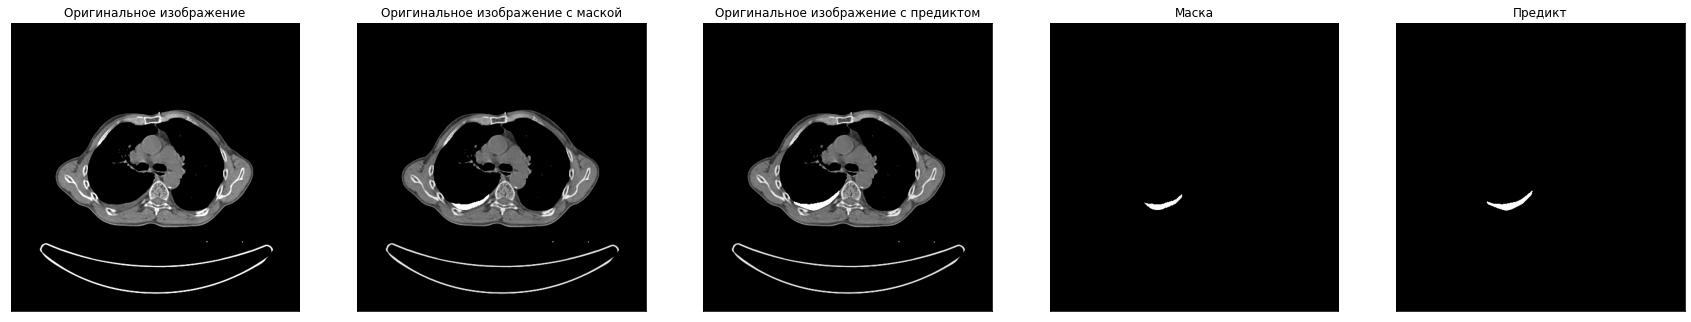

1/1 [==============================] - 0s 28ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-416/07-30-2010-NA-NA-71000/0.000000-NA-44349/1-085.dcm
Для данного кадра в левом легком обнаружено 408 пикселей выпота, объём 1167.29736328125 мм3
Для данного кадра в правом легком обнаружено 1269 пикселей выпота, объём 3630.6381225585938 мм3
Для данного кадра всего обнаружено 1677 пикселей выпота, объём 4797.935485839844 мм3


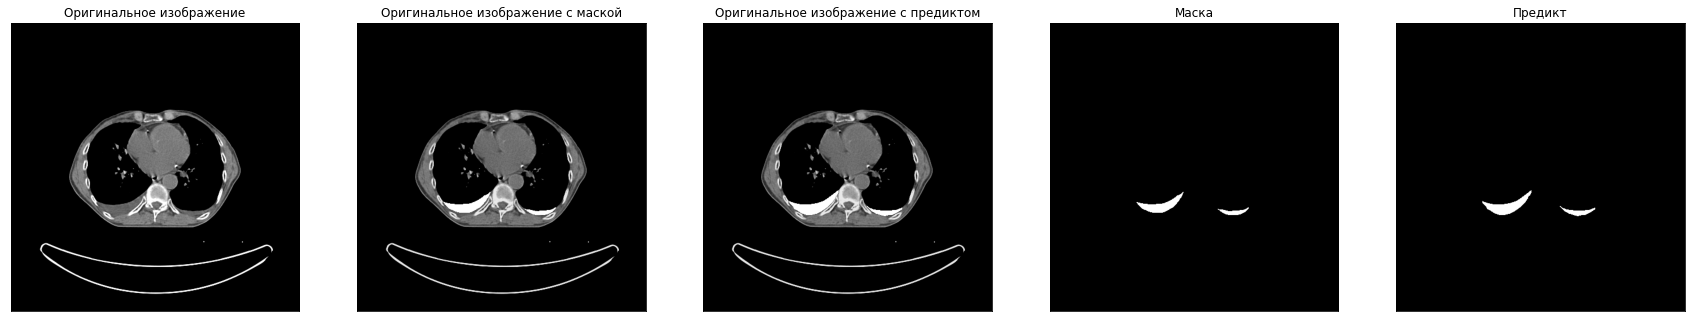

1/1 [==============================] - 0s 44ms/step

Файл: /content/TestDataSmall/DicomForTest/LUNG1-416/07-30-2010-NA-NA-71000/0.000000-NA-44349/1-123.dcm
Для данного кадра в левом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра в правом легком обнаружено 0 пикселей выпота, объём 0.0 мм3
Для данного кадра всего обнаружено 0 пикселей выпота, объём 0.0 мм3


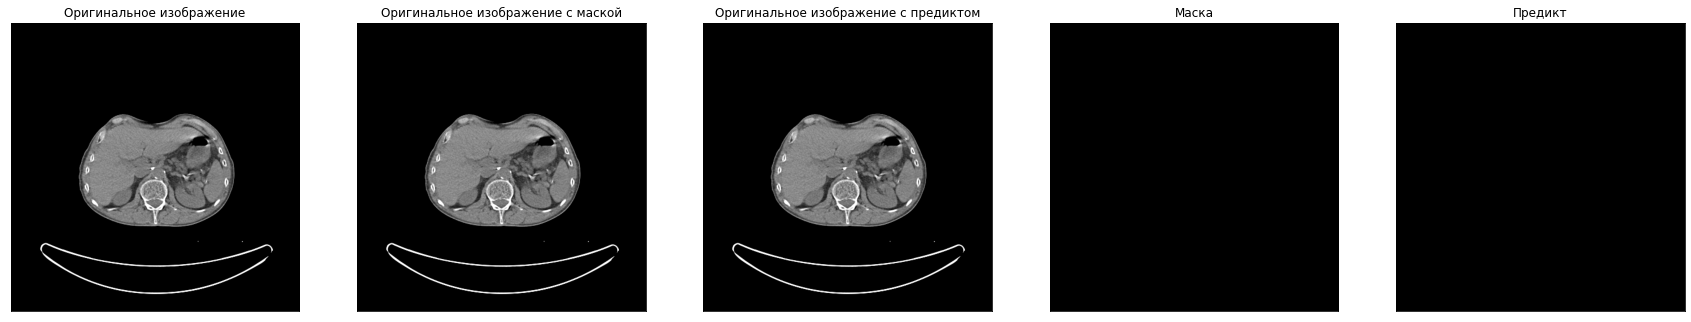

В серии обнаружено 21 кадров с выпотом
В левом легком обнаружено 6597 пикселей  с выпотом. Общий объем 18874.168395996094
В правом легком обнаружено 7632 пикселей  с выпотом. Общий объем 21835.3271484375
Всего обнаружено 14229 пикселей  с выпотом c общим объемом 40709.495544433594


In [ ]:
#делаем предикт, визуализируем все файлы, считаем для каждого файла объем выпота
TotalPixCount=0
TotalEffusionSlice=0
TotalLeftPixCount=0
TotalRightPixCount=0
TotalVolume=0
TotalLeftVolume=0
TotalRightVolume=0
for  OriginalFile in VisualOriginalFiles:
    #читаем файл Dicom
    try:
      ds = dicom.dcmread(OriginalFile,force=True)
      OriginalImg=ds.pixel_array
    except Exception as e:
      print (f'не могу прочитать файл {OriginalFile}')
      continue
    #Получаем, подготавливаем оригинальное   
    OriginalImg=np.array(OriginalImg)
    OriginalImg=preprocessing_original(OriginalImg,ds.RescaleSlope,ds.RescaleIntercept)
    #Получаем предикт модели
    PredictImg=model.predict(OriginalImg[None,...])
    PredictImg  = postprocessing_predict (PredictImg)
    MaskImg= get_mask_image(get_mask_full_path(OriginalFile))

    #Вычисления
    Middle =int(PredictImg.shape[1]/2) #центр изображения по горизонтали
    RightPixCount,RightVolume = calc_volume(PredictImg[:,0:Middle],ds) #Считаем количество пикселей и объем для правой части изображения
    LeftPixCount,LeftVolume = calc_volume(PredictImg[:,Middle:PredictImg.shape[1]],ds)  #Считаем количество пикселей и объем для левой части изображения
    PixCount=RightPixCount+LeftPixCount # Общая сумма пикселей для изображения
    Volume=LeftVolume+RightVolume  #Суммарный объем выпота для изображения
    if PixCount>0:
      TotalPixCount=TotalPixCount+PixCount
      TotalLeftPixCount=TotalLeftPixCount+LeftPixCount
      TotalRightPixCount=TotalRightPixCount+RightPixCount
      TotalVolume=TotalVolume+Volume
      TotalLeftVolume=TotalLeftVolume+LeftVolume
      TotalRightVolume=TotalRightVolume+RightVolume
      TotalEffusionSlice=TotalEffusionSlice+1
    ImageList,TitleList = get_visual_images(ShowCombinedImages,ShowPredictCombinedImages,ShowMask,ShowPredict,OriginalImg,MaskImg,PredictImg)
    print()
    print (f'Файл: {OriginalFile}')
    print (f'Для данного кадра в левом легком обнаружено {LeftPixCount} пикселей выпота, объём {LeftVolume} мм3') 
    print (f'Для данного кадра в правом легком обнаружено {RightPixCount} пикселей выпота, объём {RightVolume} мм3') 
    print (f'Для данного кадра всего обнаружено {PixCount} пикселей выпота, объём {Volume} мм3') 
    show_compare_img(ImageList,TitleList,figsize=(6,6))
#Итоги по серии
print (f'В серии обнаружено {TotalEffusionSlice} кадров с выпотом')
print (f'В левом легком обнаружено {TotalLeftPixCount} пикселей  с выпотом. Общий объем {TotalLeftVolume}')
print (f'В правом легком обнаружено {TotalRightPixCount} пикселей  с выпотом. Общий объем {TotalRightVolume}')
print (f'Всего обнаружено {TotalPixCount} пикселей  с выпотом c общим объемом {TotalVolume}')

##Сохранение результатов

In [ ]:
#Получаем предикты для каждого пациента из списка и сохраняем их в файлы 
for patient in PatientDirList:
  OriginalFiles =get_file_paths([patient])
  ImgData=get_x_test(OriginalFiles)
  #PredictImgs=model.predict(get_x_test(OriginalFiles),verbose=True)
  PatientFolderName=patient.split(os.path.sep,)[-3]
  DestPath=os.path.join(OutputFolder,PatientFolderName)
  TotalPixCount=0
  TotalEffusionSlice=0
  TotalLeftPixCount=0
  TotalRightPixCount=0
  TotalVolume=0
  TotalLeftVolume=0
  TotalRightVolume=0
  if not os.path.isdir(DestPath):
    os.makedirs(DestPath)
  for  OriginalFile in OriginalFiles:
    FileName=OriginalFile.split(os.path.sep,)[-1]
    DestFileName=os.path.join(DestPath,FileName)
    try:
      ds = dicom.dcmread(OriginalFile,force=True)
      OriginalImg=ds.pixel_array
    except Exception as e:
      print (f'не могу прочитать файл {OriginalFile}')
      continue
    OriginalImg=np.array(OriginalImg)
    OriginalImagePreprocessed=preprocessing_original(OriginalImg,ds.RescaleSlope,ds.RescaleIntercept)# Это будем подавать в сеть
    OriginalImg= resize_img (OriginalImg)# это будем сохранять в файл

    PredictImg=model.predict(OriginalImagePreprocessed[None,...])
    PredictImg  = postprocessing_predict (PredictImg)
    Middle =int(PredictImg.shape[1]/2) #центр изображения по горизонтали
    RightPixCount,RightVolume = calc_volume(PredictImg[:,0:Middle],ds) #Считаем количество пикселей и объем для правой части изображения
    LeftPixCount,LeftVolume = calc_volume(PredictImg[:,Middle:PredictImg.shape[1]],ds)  #Считаем количество пикселей и объем для левой части изображения
    PixCount=RightPixCount+LeftPixCount # Общая сумма пикселей для изображения
    Volume=LeftVolume+RightVolume  #Суммарный объем выпота для изображения
    if PixCount>0:
      TotalPixCount=TotalPixCount+PixCount
      TotalLeftPixCount=TotalLeftPixCount+LeftPixCount
      TotalRightPixCount=TotalRightPixCount+RightPixCount
      TotalVolume=TotalVolume+Volume
      TotalLeftVolume=TotalLeftVolume+LeftVolume
      TotalRightVolume=TotalRightVolume+RightVolume
      TotalEffusionSlice=TotalEffusionSlice+1
    #Формирование  и сохранение изображения
    CombineImg=combine_original_mask(OriginalImg,PredictImg)
    CombineImg=CombineImg/np.max(CombineImg)*65535
    CombineImg=CombineImg.astype(np.uint16)
    img = Image.fromarray(CombineImg)
    DestFileName = DestFileName+'.png'
    img.save(DestFileName)
  #Итоги по пациенту
  print (f'Для пациента {patient} обнаружено {TotalEffusionSlice} кадров с выпотом')
  print (f'В левом легком обнаружено {TotalLeftPixCount} пикселей  с выпотом. Общий объем {TotalLeftVolume}')
  print (f'В правом легком обнаружено {TotalRightPixCount} пикселей  с выпотом. Общий объем {TotalRightVolume}')
  print (f'Всего обнаружено {TotalPixCount} пикселей  с выпотом c общим объемом {TotalVolume}')

1/1 [==============================] - 0s 18ms/step
Для пациента /content/TestData/DicomForTest/LUNG1-343/05-14-2009-StudyID-NA-95338/0.000000-NA-84394 обнаружено 58 кадров с выпотом
В левом легком обнаружено 62186 пикселей  с выпотом. Общий объем 177915.5731201172
В правом легком обнаружено 189 пикселей  с выпотом. Общий объем 540.7333374023438
Всего обнаружено 62375 пикселей  с выпотом c общим объемом 178456.30645751953
1/1 [==============================] - 0s 29ms/step
Для пациента /content/TestData/DicomForTest/LUNG1-361/04-11-2010-NA-NA-81795/0.000000-NA-56193 обнаружено 39 кадров с выпотом
В левом легком обнаружено 106 пикселей  с выпотом. Общий объем 303.2684326171875
В правом легком обнаружено 14378 пикселей  с выпотом. Общий объем 41135.78796386719
Всего обнаружено 14484 пикселей  с выпотом c общим объемом 41439.056396484375
1/1 [==============================] - 0s 24ms/step
Для пациента /content/TestData/DicomForTest/LUNG1-366/04-12-2010-NA-NA-44824/0.000000-NA-58053 обнару